In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import networkx as nx
from collections import defaultdict
import heapq
import time

# Load the map
map_df = pd.read_csv('map.csv', header=None)
terrain_map = map_df.values
n_rows, n_cols = terrain_map.shape

print(f"Map size: {n_rows} x {n_cols}")
print(f"Map:\n{terrain_map}")

Map size: 20 x 30
Map:
[[5 5 4 4 2 2 6 4 1 4 5 2 1 3 2 1 2 6 4 6 5 6 6 3 2 4 4 1 6 1]
 [6 3 5 4 4 6 3 2 3 4 4 3 1 4 6 1 5 2 5 2 4 5 4 5 2 6 5 3 4 6]
 [2 3 2 1 5 2 5 2 2 3 2 4 6 2 5 5 1 3 3 1 4 6 2 4 4 4 4 6 2 1]
 [5 5 2 6 2 2 1 3 4 1 1 4 6 2 6 3 4 5 6 5 1 3 4 2 2 4 1 2 6 5]
 [4 6 4 5 5 2 2 2 6 6 1 5 1 6 5 6 4 3 3 4 4 6 2 6 3 1 3 5 5 6]
 [3 2 2 4 5 4 4 6 4 1 4 3 6 1 1 3 1 3 5 2 3 2 4 6 4 3 5 5 1 6]
 [3 5 4 1 3 3 3 1 3 2 6 6 5 1 1 2 3 1 4 5 2 1 5 1 5 1 1 4 1 5]
 [3 1 3 1 5 5 6 4 3 5 3 5 3 6 2 1 6 1 6 2 4 2 5 4 3 2 6 2 5 5]
 [1 2 5 6 6 5 3 3 4 4 5 3 6 5 1 5 1 6 3 6 6 1 4 2 3 3 2 4 5 1]
 [6 4 3 2 4 2 2 5 4 6 1 1 3 6 6 1 1 2 2 4 3 5 6 3 2 5 5 2 1 4]
 [2 2 1 3 2 2 6 5 4 3 3 6 6 2 6 2 5 2 5 6 4 3 4 6 1 6 3 5 3 2]
 [5 1 6 3 2 5 5 1 1 4 4 5 4 3 4 6 6 3 2 5 3 6 3 4 2 2 4 1 4 1]
 [3 1 2 5 1 4 5 1 4 2 2 6 4 6 2 4 2 2 6 6 2 6 3 5 6 2 4 4 4 2]
 [1 4 1 4 2 3 2 1 2 1 5 6 4 5 1 1 6 2 3 2 4 4 2 6 4 5 4 1 3 5]
 [1 4 3 3 5 5 5 6 6 5 5 2 4 5 3 2 6 2 6 6 3 6 3 1 3 2 2 4 5 3]
 [2 5 6 6 6 2 5 6 1 4 4 4 6 1 2 

In [2]:
# Terrain types
TERRAIN = {
    1: 'City',
    2: 'Mountain',
    3: 'Grassland',
    4: 'Forest',
    5: 'Desert',
    6: 'Swamp'
}

# Path costs (added from adjacent regions)
PATH_COSTS = {
    1: 20,   # City
    2: 60,   # Mountain
    3: 40,   # Grassland
    4: 50,   # Forest
    5: 90,   # Desert
    6: 110   # Swamp
}

# Inventory setup costs (per adjacent region)
INVENTORY_SETUP_COSTS = {
    1: 1200,  # City
    2: 600,   # Mountain
    3: 1000,  # Grassland
    4: 700,   # Forest
    5: 500,   # Desert
    6: 300    # Swamp
}

# Inventory capacity (per adjacent region)
INVENTORY_CAPACITY = {
    1: 15,   # City
    2: 20,   # Mountain
    3: 15,   # Grassland
    4: 10,   # Forest
    5: 30,   # Desert
    6: 25    # Swamp
}

# Harbors (ports) - left boundary
harbour = {
    0: 0, 1: 85, 2: 0, 3: 120, 4: 0, 5: 95, 6: 0, 7: 0, 8: 150, 9: 0,
    10: 0, 11: 110, 12: 0, 13: 0, 14: 75, 15: 0, 16: 130, 17: 0, 18: 0, 19: 90
}

# Stores - right boundary
stores = {
    0: 40, 1: 0, 2: 95, 3: 0, 4: 120, 5: 0, 6: 85, 7: 0, 8: 0, 9: 110,
    10: 0, 11: 0, 12: 75, 13: 0, 14: 0, 15: 130, 16: 0, 17: 80, 18: 105, 19: 15
}

# Constraints
MIN_WAREHOUSES = 3
MAX_WAREHOUSES = 8
MIN_DISTANCE = 3  # Minimum distance between warehouses and from ports
PENALTY_COST = 10000  # Shortage penalty

# Extract active harbors and stores
active_harbors = [(i, harbour[i]) for i in range(n_rows) if harbour[i] > 0]
active_stores = [(i, stores[i]) for i in range(n_rows) if stores[i] > 0]

print(f"Active harbors: {len(active_harbors)}")
print(f"Active stores: {len(active_stores)}")
print(f"Total supply: {sum(s for _, s in active_harbors)}")
print(f"Total demand: {sum(d for _, d in active_stores)}")

Active harbors: 8
Active stores: 10
Total supply: 855
Total demand: 855


In [3]:
def get_intersection_points():
    """Get all valid intersection points for warehouses"""
    intersections = []
    # Intersections are at grid points between cells
    for i in range(n_rows + 1):
        for j in range(n_cols + 1):
            intersections.append((i, j))
    return intersections

def get_adjacent_terrains(intersection):
    """Get terrains adjacent to an intersection point"""
    i, j = intersection
    adjacent = []

    # Four possible adjacent cells: top-left, top-right, bottom-left, bottom-right
    positions = [
        (i-1, j-1),  # top-left
        (i-1, j),    # top-right
        (i, j-1),    # bottom-left
        (i, j)       # bottom-right
    ]

    for r, c in positions:
        if 0 <= r < n_rows and 0 <= c < n_cols:
            adjacent.append(terrain_map[r, c])

    return adjacent

def calculate_warehouse_cost(intersection):
    """Calculate setup cost for a warehouse at given intersection"""
    terrains = get_adjacent_terrains(intersection)
    return sum(INVENTORY_SETUP_COSTS[t] for t in terrains)

def calculate_warehouse_capacity(intersection):
    """Calculate capacity for a warehouse at given intersection"""
    terrains = get_adjacent_terrains(intersection)
    return sum(INVENTORY_CAPACITY[t] for t in terrains)

def get_path_cost(r1, c1, r2, c2):
    """Calculate cost of path between two adjacent cells"""
    if abs(r1 - r2) + abs(c1 - c2) != 1:
        return float('inf')  # Not adjacent

    terrain1 = terrain_map[r1, c1]
    terrain2 = terrain_map[r2, c2]

    # Cannot move between same terrain types
    if terrain1 == terrain2:
        return float('inf')

    return PATH_COSTS[terrain1] + PATH_COSTS[terrain2]

print("Helper functions defined successfully!")

Helper functions defined successfully!


In [4]:
def build_graph():
    """Build graph representation of the map"""
    G = nx.Graph()

    # Add nodes (cells)
    for i in range(n_rows):
        for j in range(n_cols):
            G.add_node((i, j))

    # Add edges with costs
    for i in range(n_rows):
        for j in range(n_cols):
            # Check right neighbor
            if j + 1 < n_cols:
                cost = get_path_cost(i, j, i, j + 1)
                if cost < float('inf'):
                    G.add_edge((i, j), (i, j + 1), weight=cost)

            # Check bottom neighbor
            if i + 1 < n_rows:
                cost = get_path_cost(i, j, i + 1, j)
                if cost < float('inf'):
                    G.add_edge((i, j), (i + 1, j), weight=cost)

    return G

def shortest_path_cost(G, source, target):
    """Calculate shortest path cost between two nodes"""
    try:
        path_length = nx.shortest_path_length(G, source, target, weight='weight')
        return path_length
    except nx.NetworkXNoPath:
        return float('inf')

def manhattan_distance(p1, p2):
    """Calculate Manhattan distance between two points"""
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

# Build the graph
G = build_graph()
print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph built with 600 nodes and 948 edges


In [5]:
def filter_valid_warehouses():
    """Filter warehouse locations based on distance constraints"""
    all_intersections = get_intersection_points()
    valid_warehouses = []

    # Harbor positions (on left boundary, column 0)
    harbor_positions = [(i, 0) for i, supply in active_harbors]

    for intersection in all_intersections:
        i, j = intersection

        # Must be between harbors (left) and stores (right)
        if j <= 0 or j >= n_cols:
            continue

        # Check minimum distance from harbors (at least 3 edges)
        too_close = False
        for h_row, _ in active_harbors:
            # Distance from intersection to harbor cell
            dist = manhattan_distance((i, j), (h_row, 0))
            if dist < MIN_DISTANCE:
                too_close = True
                break

        if not too_close:
            setup_cost = calculate_warehouse_cost(intersection)
            capacity = calculate_warehouse_capacity(intersection)
            valid_warehouses.append({
                'position': intersection,
                'setup_cost': setup_cost,
                'capacity': capacity
            })

    return valid_warehouses

valid_warehouses = filter_valid_warehouses()
print(f"Valid warehouse locations: {len(valid_warehouses)}")
print(f"First 5 warehouses: {valid_warehouses[:5]}")

Valid warehouse locations: 580
First 5 warehouses: [{'position': (0, 2), 'setup_cost': 1200, 'capacity': 40}, {'position': (0, 3), 'setup_cost': 1400, 'capacity': 20}, {'position': (0, 4), 'setup_cost': 1300, 'capacity': 30}, {'position': (0, 5), 'setup_cost': 1200, 'capacity': 40}, {'position': (0, 6), 'setup_cost': 900, 'capacity': 45}]


In [6]:
def calculate_transportation_costs():
    """Calculate costs from harbors to warehouses to stores"""
    costs = {}

    print("Calculating transportation costs...")

    for h_idx, (h_row, h_supply) in enumerate(active_harbors):
        harbor_cell = (h_row, 0)  # Left boundary

        for w_idx, warehouse in enumerate(valid_warehouses):
            w_pos = warehouse['position']
            # Warehouse is at intersection, use nearest cell
            w_cell = (min(w_pos[0], n_rows-1), min(w_pos[1], n_cols-1))

            for s_idx, (s_row, s_demand) in enumerate(active_stores):
                store_cell = (s_row, n_cols - 1)  # Right boundary

                # Cost = harbor to warehouse + warehouse to store
                cost_h_to_w = shortest_path_cost(G, harbor_cell, w_cell)
                cost_w_to_s = shortest_path_cost(G, w_cell, store_cell)

                total_cost = cost_h_to_w + cost_w_to_s
                costs[(h_idx, w_idx, s_idx)] = total_cost

    return costs

transportation_costs = calculate_transportation_costs()
print(f"Transportation cost matrix calculated: {len(transportation_costs)} entries")

Calculating transportation costs...
Transportation cost matrix calculated: 46400 entries


In [7]:
def generate_minizinc_model():
    """Generate the MiniZinc model with all constraints"""

    model = r"""
% Supply Chain Network Optimization Model

% Parameters
int: n_harbors;
int: n_warehouses;
int: n_stores;
int: min_warehouses;
int: max_warehouses;
int: penalty_cost;

array[1..n_harbors] of int: supply;
array[1..n_stores] of int: demand;
array[1..n_warehouses] of int: warehouse_setup_cost;
array[1..n_warehouses] of int: warehouse_capacity;
array[1..n_harbors, 1..n_warehouses, 1..n_stores] of int: transport_cost;

% Distance matrix between warehouses (for minimum distance constraint)
array[1..n_warehouses, 1..n_warehouses] of int: warehouse_distances;
int: min_distance;

% Decision Variables
array[1..n_harbors, 1..n_warehouses, 1..n_stores] of var 0..10000: flow;
array[1..n_warehouses] of var 0..1: warehouse_open;
array[1..n_stores] of var 0..10000: shortage;

% Objective: Minimize total cost
var int: total_transport_cost = sum(i in 1..n_harbors, j in 1..n_warehouses, k in 1..n_stores)(
    transport_cost[i,j,k] * flow[i,j,k]
);

var int: total_setup_cost = sum(j in 1..n_warehouses)(
    warehouse_setup_cost[j] * warehouse_open[j]
);

var int: total_penalty = sum(k in 1..n_stores)(
    penalty_cost * shortage[k]
);

var int: total_cost = total_transport_cost + total_setup_cost + total_penalty;

% Constraints

% 1. Demand satisfaction (with shortage allowed)
constraint forall(k in 1..n_stores)(
    sum(i in 1..n_harbors, j in 1..n_warehouses)(flow[i,j,k]) + shortage[k] = demand[k]
);

% 2. Supply limits
constraint forall(i in 1..n_harbors)(
    sum(j in 1..n_warehouses, k in 1..n_stores)(flow[i,j,k]) <= supply[i]
);

% 3. Warehouse capacity (flow only if open)
constraint forall(j in 1..n_warehouses)(
    sum(i in 1..n_harbors, k in 1..n_stores)(flow[i,j,k]) <= warehouse_capacity[j] * warehouse_open[j]
);

% 4. Number of warehouses constraint
constraint sum(j in 1..n_warehouses)(warehouse_open[j]) >= min_warehouses;
constraint sum(j in 1..n_warehouses)(warehouse_open[j]) <= max_warehouses;

% 5. Minimum distance between warehouses
constraint forall(j1 in 1..n_warehouses, j2 in j1+1..n_warehouses)(
    warehouse_open[j1] + warehouse_open[j2] <= 1 \/ warehouse_distances[j1,j2] >= min_distance
);

% Solve
solve minimize total_cost;

% Output
output [
    "Total Cost: ", show(total_cost), "\n",
    "Transport Cost: ", show(total_transport_cost), "\n",
    "Setup Cost: ", show(total_setup_cost), "\n",
    "Penalty Cost: ", show(total_penalty), "\n",
    "Warehouses Open: ", show(sum(j in 1..n_warehouses)(warehouse_open[j])), "\n",
    "Warehouse Locations: ", show([j | j in 1..n_warehouses where warehouse_open[j] = 1]), "\n"
];
"""

    return model

In [8]:
def calculate_warehouse_distance(w1_pos, w2_pos):
    """Calculate distance between two warehouses"""
    return manhattan_distance(w1_pos, w2_pos)

def generate_minizinc_data():
    """Generate the data file for MiniZinc"""

    n_harbors = len(active_harbors)
    n_stores = len(active_stores)
    n_warehouses = len(valid_warehouses)

    # Build data string
    data = f"n_harbors = {n_harbors};\n"
    data += f"n_warehouses = {n_warehouses};\n"
    data += f"n_stores = {n_stores};\n"
    data += f"min_warehouses = {MIN_WAREHOUSES};\n"
    data += f"max_warehouses = {MAX_WAREHOUSES};\n"
    data += f"penalty_cost = {PENALTY_COST};\n"
    data += f"min_distance = {MIN_DISTANCE};\n\n"

    # Supply array
    supply_values = [supply for _, supply in active_harbors]
    data += f"supply = {supply_values};\n\n"

    # Demand array
    demand_values = [demand for _, demand in active_stores]
    data += f"demand = {demand_values};\n\n"

    # Warehouse setup costs
    setup_costs = [w['setup_cost'] for w in valid_warehouses]
    data += f"warehouse_setup_cost = {setup_costs};\n\n"

    # Warehouse capacities
    capacities = [w['capacity'] for w in valid_warehouses]
    data += f"warehouse_capacity = {capacities};\n\n"

    # Transportation costs (3D array)
    data += "transport_cost = array3d(1..{}, 1..{}, 1..{}, [\n".format(
        n_harbors, n_warehouses, n_stores
    )

    for h_idx in range(n_harbors):
        for w_idx in range(n_warehouses):
            for s_idx in range(n_stores):
                cost = transportation_costs.get((h_idx, w_idx, s_idx), 99999)
                if cost == float('inf'):
                    cost = 99999
                data += f"  {int(cost)},\n"

    data = data.rstrip(',\n') + "\n]);\n\n"

    # Warehouse distances (2D array)
    data += "warehouse_distances = array2d(1..{}, 1..{}, [\n".format(
        n_warehouses, n_warehouses
    )

    for w1_idx in range(n_warehouses):
        for w2_idx in range(n_warehouses):
            if w1_idx == w2_idx:
                dist = 0
            else:
                w1_pos = valid_warehouses[w1_idx]['position']
                w2_pos = valid_warehouses[w2_idx]['position']
                dist = calculate_warehouse_distance(w1_pos, w2_pos)
            data += f"  {dist},\n"

    data = data.rstrip(',\n') + "\n]);\n"

    return data

# Generate and save the data
dzn_data = generate_minizinc_data()

with open('supply_chain.dzn', 'w') as f:
    f.write(dzn_data)

print("MiniZinc data saved to 'supply_chain.dzn'")
print(f"\nData summary:")
print(f"- Harbors: {len(active_harbors)}")
print(f"- Warehouses: {len(valid_warehouses)}")
print(f"- Stores: {len(active_stores)}")

MiniZinc data saved to 'supply_chain.dzn'

Data summary:
- Harbors: 8
- Warehouses: 580
- Stores: 10


In [9]:
def greedy_heuristic():
    """
    Greedy heuristic for Part 1:
    1. Select warehouses with best cost/capacity ratio
    2. Route flow greedily based on minimum cost paths
    """

    start_time = time.time()

    # Step 1: Score warehouses
    warehouse_scores = []
    for w_idx, warehouse in enumerate(valid_warehouses):
        # Score = capacity / setup_cost (higher is better)
        score = warehouse['capacity'] / max(warehouse['setup_cost'], 1)
        warehouse_scores.append((score, w_idx, warehouse))

    # Sort by score (descending)
    warehouse_scores.sort(reverse=True)

    # Step 2: Select warehouses respecting distance constraints
    selected_warehouses = []
    selected_indices = []

    for score, w_idx, warehouse in warehouse_scores:
        if len(selected_warehouses) >= MAX_WAREHOUSES:
            break

        w_pos = warehouse['position']

        # Check distance from already selected warehouses
        valid = True
        for other_idx in selected_indices:
            other_pos = valid_warehouses[other_idx]['position']
            if calculate_warehouse_distance(w_pos, other_pos) < MIN_DISTANCE:
                valid = False
                break

        # Check distance from harbors
        for h_row, _ in active_harbors:
            if manhattan_distance(w_pos, (h_row, 0)) < MIN_DISTANCE:
                valid = False
                break

        if valid:
            selected_warehouses.append(warehouse)
            selected_indices.append(w_idx)

    # Ensure minimum warehouses
    if len(selected_warehouses) < MIN_WAREHOUSES:
        print(f"Warning: Only {len(selected_warehouses)} valid warehouses found (min: {MIN_WAREHOUSES})")

    # Step 3: Route flow greedily
    total_cost = 0
    total_setup_cost = sum(w['setup_cost'] for w in selected_warehouses)
    total_transport_cost = 0
    total_shortage = 0

    # Initialize flow
    warehouse_used = {i: 0 for i in range(len(selected_warehouses))}
    store_fulfilled = {i: 0 for i in range(len(active_stores))}
    harbor_remaining = {i: supply for i, (_, supply) in enumerate(active_harbors)}

    # For each store, find cheapest routes
    for s_idx, (s_row, s_demand) in enumerate(active_stores):
        remaining_demand = s_demand

        # Create list of (cost, harbor_idx, warehouse_idx)
        routes = []
        for h_idx in range(len(active_harbors)):
            for w_idx_local, w_idx_global in enumerate(selected_indices):
                cost = transportation_costs.get((h_idx, w_idx_global, s_idx), float('inf'))
                if cost < float('inf'):
                    routes.append((cost, h_idx, w_idx_local, w_idx_global))

        # Sort by cost
        routes.sort()

        # Allocate flow
        for cost, h_idx, w_idx_local, w_idx_global in routes:
            if remaining_demand <= 0:
                break

            # How much can we send?
            available_supply = harbor_remaining[h_idx]
            available_capacity = selected_warehouses[w_idx_local]['capacity'] - warehouse_used[w_idx_local]

            flow_amount = min(remaining_demand, available_supply, available_capacity)

            if flow_amount > 0:
                total_transport_cost += cost * flow_amount
                warehouse_used[w_idx_local] += flow_amount
                harbor_remaining[h_idx] -= flow_amount
                remaining_demand -= flow_amount

        # If still have remaining demand, add shortage penalty
        if remaining_demand > 0:
            total_shortage += remaining_demand

    total_penalty_cost = total_shortage * PENALTY_COST
    total_cost = total_setup_cost + total_transport_cost + total_penalty_cost

    end_time = time.time()

    result = {
        'total_cost': total_cost,
        'setup_cost': total_setup_cost,
        'transport_cost': total_transport_cost,
        'penalty_cost': total_penalty_cost,
        'shortage': total_shortage,
        'warehouses_opened': len(selected_warehouses),
        'warehouse_locations': [w['position'] for w in selected_warehouses],
        'time_seconds': end_time - start_time
    }

    return result

# Run the greedy heuristic
print("=" * 60)
print("PART 1: GREEDY HEURISTIC SOLUTION")
print("=" * 60)

greedy_result = greedy_heuristic()

print(f"\nResults:")
print(f"Total Cost: {greedy_result['total_cost']:,.0f}")
print(f"  - Setup Cost: {greedy_result['setup_cost']:,.0f}")
print(f"  - Transport Cost: {greedy_result['transport_cost']:,.0f}")
print(f"  - Penalty Cost: {greedy_result['penalty_cost']:,.0f}")
print(f"Shortage: {greedy_result['shortage']}")
print(f"Warehouses Opened: {greedy_result['warehouses_opened']}")
print(f"Warehouse Locations: {greedy_result['warehouse_locations'][:5]}...")  # Show first 5
print(f"Computation Time: {greedy_result['time_seconds']:.3f} seconds")

PART 1: GREEDY HEURISTIC SOLUTION

Results:
Total Cost: 4,653,150
  - Setup Cost: 10,200
  - Transport Cost: 2,942,950
  - Penalty Cost: 1,700,000
Shortage: 170
Warehouses Opened: 8
Warehouse Locations: [(0, 22), (20, 26), (20, 8), (15, 7), (4, 29)]...
Computation Time: 0.001 seconds


In [10]:
print("=" * 60)
print("PART 2: MINIZINC SOLUTION")
print("=" * 60)
print("\nFiles generated:")
print("1. supply_chain.mzn - The model file")
print("2. supply_chain.dzn - The data file")
print("\nTo run in MiniZinc IDE:")
print("1. Open MiniZinc IDE")
print("2. Open 'supply_chain.mzn'")
print("3. Set data file to 'supply_chain.dzn' (in the IDE)")
print("4. Select solver (e.g., Gecode, Chuffed, or Coin-BC)")
print("5. Click 'Run' or press Ctrl+R")
print("\nOr run from command line:")
print("minizinc --solver Gecode supply_chain.mzn supply_chain.dzn")
print("\n" + "=" * 60)

PART 2: MINIZINC SOLUTION

Files generated:
1. supply_chain.mzn - The model file
2. supply_chain.dzn - The data file

To run in MiniZinc IDE:
1. Open MiniZinc IDE
2. Open 'supply_chain.mzn'
3. Set data file to 'supply_chain.dzn' (in the IDE)
4. Select solver (e.g., Gecode, Chuffed, or Coin-BC)
5. Click 'Run' or press Ctrl+R

Or run from command line:
minizinc --solver Gecode supply_chain.mzn supply_chain.dzn



In [20]:
def generate_bonus_minizinc_model():
    """
    Bonus Part: Modified constraints
    - Each supplier transfers to exactly one warehouse
    - Infinite warehouse capacity
    - Each customer receives from exactly one warehouse
    """

    model = r"""
% Bonus Part: Supply Chain with Single Assignment

% Parameters
int: n_harbors;
int: n_warehouses;
int: n_stores;
int: min_warehouses;
int: max_warehouses;
int: penalty_cost;  % Accept but don't use (for compatibility)

array[1..n_harbors] of int: supply;
array[1..n_stores] of int: demand;
array[1..n_warehouses] of int: warehouse_setup_cost;
array[1..n_warehouses] of int: warehouse_capacity;  % Accept but don't use (infinite capacity)
array[1..n_harbors, 1..n_warehouses, 1..n_stores] of int: transport_cost;
array[1..n_warehouses, 1..n_warehouses] of int: warehouse_distances;
int: min_distance;

% Decision Variables
array[1..n_harbors] of var 1..n_warehouses: harbor_assignment;
array[1..n_stores] of var 1..n_warehouses: store_assignment;
array[1..n_warehouses] of var 0..1: warehouse_open;

% Helper: Flow matrix (for cost calculation)
array[1..n_harbors, 1..n_warehouses, 1..n_stores] of var 0..100000: flow;

% Objective: Minimize total cost
var int: total_transport_cost = sum(i in 1..n_harbors, j in 1..n_warehouses, k in 1..n_stores)(
    transport_cost[i, j, k] * flow[i, j, k]
);

var int: total_setup_cost = sum(j in 1..n_warehouses)(
    warehouse_setup_cost[j] * warehouse_open[j]
);

var int: total_cost = total_transport_cost + total_setup_cost;

% Constraints

% 1. Harbors can only assign to open warehouses
constraint forall(i in 1..n_harbors)(
    warehouse_open[harbor_assignment[i]] = 1
);

% 2. Stores can only be served by open warehouses
constraint forall(k in 1..n_stores)(
    warehouse_open[store_assignment[k]] = 1
);

% 3. Flow only happens through assigned warehouse
constraint forall(i in 1..n_harbors, j in 1..n_warehouses, k in 1..n_stores)(
    if harbor_assignment[i] != j \/ store_assignment[k] != j then
        flow[i, j, k] = 0
    else
        true
    endif
);

% 4. Each harbor sends all its supply through its assigned warehouse
constraint forall(i in 1..n_harbors)(
    sum(k in 1..n_stores where store_assignment[k] = harbor_assignment[i])(
        flow[i, harbor_assignment[i], k]
    ) = supply[i]
);

% 5. Each store receives all its demand from its assigned warehouse
constraint forall(k in 1..n_stores)(
    sum(i in 1..n_harbors where harbor_assignment[i] = store_assignment[k])(
        flow[i, store_assignment[k], k]
    ) = demand[k]
);

% 6. Number of warehouses constraint
constraint sum(j in 1..n_warehouses)(warehouse_open[j]) >= min_warehouses;
constraint sum(j in 1..n_warehouses)(warehouse_open[j]) <= max_warehouses;

% 7. Minimum distance between warehouses
constraint forall(j1 in 1..n_warehouses, j2 in j1+1..n_warehouses)(
    warehouse_open[j1] + warehouse_open[j2] <= 1 \/ warehouse_distances[j1,j2] >= min_distance
);

% Note: No capacity constraint - warehouses have infinite capacity in bonus part

% Solve
solve minimize total_cost;

% Output
output [
    "Total Cost: ", show(total_cost), "\n",
    "Transport Cost: ", show(total_transport_cost), "\n",
    "Setup Cost: ", show(total_setup_cost), "\n",
    "Penalty Cost: 0\n",
    "Warehouses Open: ", show(sum(j in 1..n_warehouses)(warehouse_open[j])), "\n",
    "Warehouse Locations: ", show([j | j in 1..n_warehouses where warehouse_open[j] = 1]), "\n",
    "Harbor Assignments: ", show(harbor_assignment), "\n",
    "Store Assignments: ", show(store_assignment), "\n"
];
"""

    return model

# Generate bonus model
bonus_model = generate_bonus_minizinc_model()

with open('supply_chain_bonus.mzn', 'w') as f:
    f.write(bonus_model)

print("✓ Bonus MiniZinc model saved to 'supply_chain_bonus.mzn'")
print("✓ Compatible with 'supply_chain.dzn' (accepts all parameters)")
print("\n🎯 Key Features of Bonus Model:")
print("  - Infinite warehouse capacity (no capacity constraints)")
print("  - Each harbor → exactly ONE warehouse")
print("  - Each store ← exactly ONE warehouse")
print("  - No penalty cost (supply = demand by design)")
print("\n📋 To run in MiniZinc IDE:")
print("  1. Open: supply_chain_bonus.mzn")
print("  2. Data: supply_chain.dzn")
print("  3. Solver: Gecode (or Chuffed)")
print("  4. Click Run ✅")

✓ Bonus MiniZinc model saved to 'supply_chain_bonus.mzn'
✓ Compatible with 'supply_chain.dzn' (accepts all parameters)

🎯 Key Features of Bonus Model:
  - Infinite warehouse capacity (no capacity constraints)
  - Each harbor → exactly ONE warehouse
  - Each store ← exactly ONE warehouse
  - No penalty cost (supply = demand by design)

📋 To run in MiniZinc IDE:
  1. Open: supply_chain_bonus.mzn
  2. Data: supply_chain.dzn
  3. Solver: Gecode (or Chuffed)
  4. Click Run ✅


VISUALIZATION - MAP AND CONFIGURATION


C:\Users\prca\AppData\Local\Temp\ipykernel_7636\1013457386.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


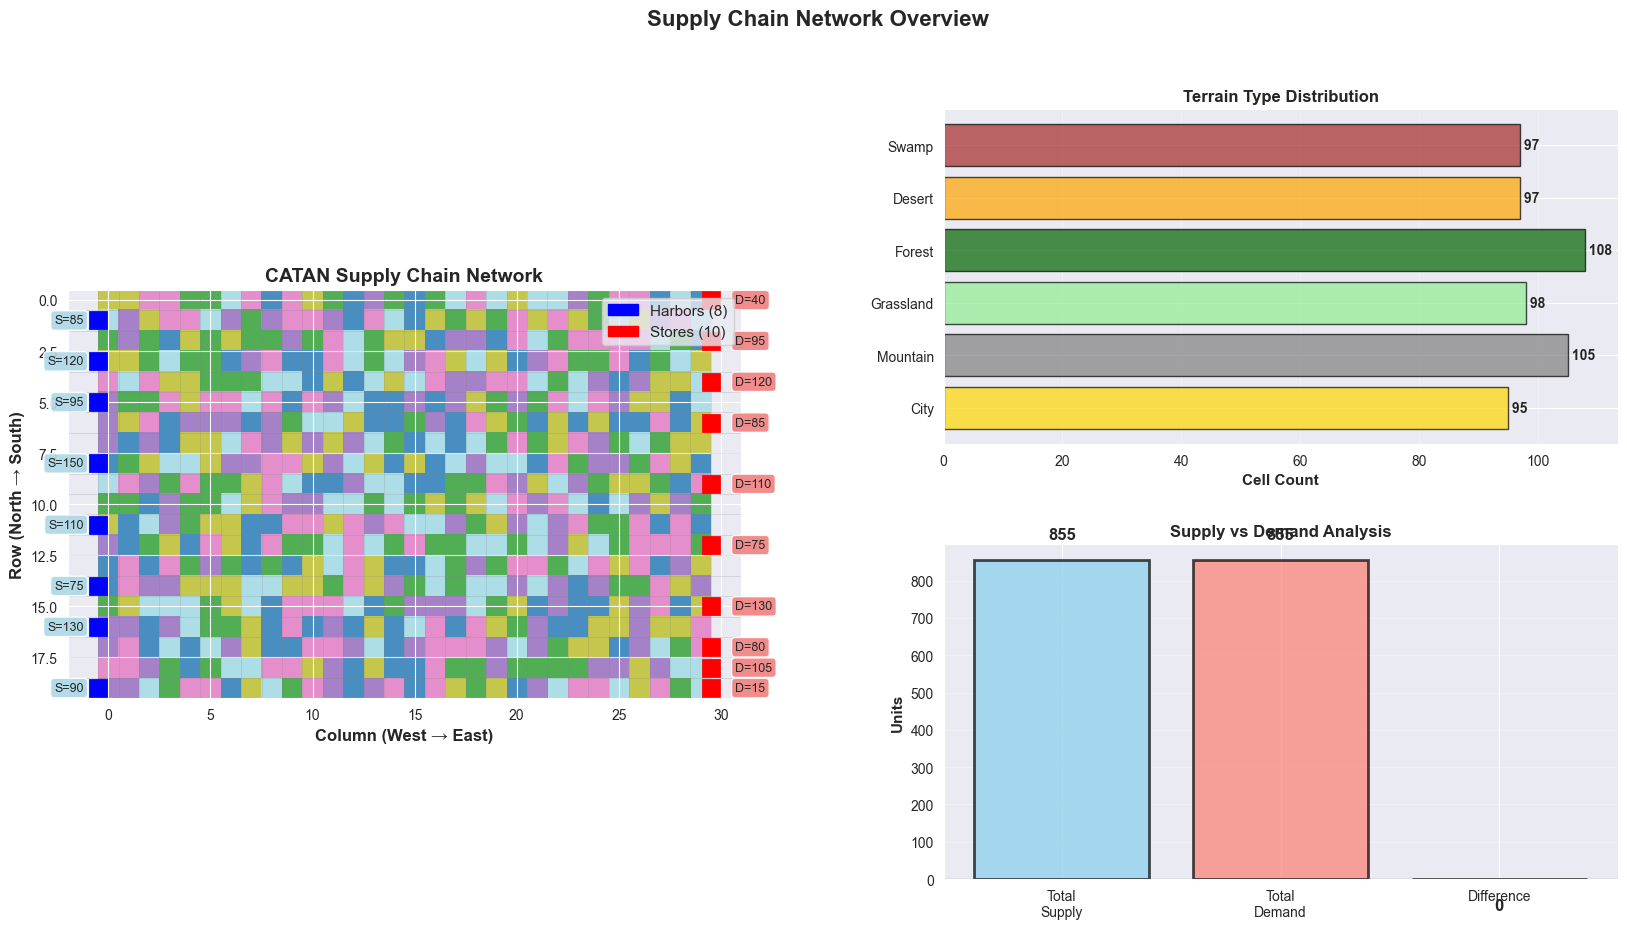


✓ Map visualization complete!
  - Total Supply: 855
  - Total Demand: 855
  - Balance: 0 units


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import csv

print("="*60)
print("VISUALIZATION - MAP AND CONFIGURATION")
print("="*60)

# Create figure with subplots
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Subplot 1: Main map with harbors and stores
ax1 = fig.add_subplot(gs[:, 0])
im = ax1.imshow(terrain_map, cmap='tab20', interpolation='nearest', alpha=0.8)

# Add grid lines
for i in range(n_rows + 1):
    ax1.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.3)
for j in range(n_cols + 1):
    ax1.axvline(j - 0.5, color='gray', linewidth=0.5, alpha=0.3)

# Mark harbors (left boundary)
for i, supply in harbour.items():
    if supply > 0:
        ax1.plot(-0.5, i, 'bs', markersize=12, markeredgewidth=2)
        ax1.text(-1.2, i, f'S={supply}', fontsize=9, ha='right', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.9))

# Mark stores (right boundary)
for i, demand in stores.items():
    if demand > 0:
        ax1.plot(n_cols - 0.5, i, 'rs', markersize=12, markeredgewidth=2)
        ax1.text(n_cols + 0.7, i, f'D={demand}', fontsize=9, ha='left', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.9))

# Create custom legend
harbor_patch = mpatches.Patch(color='blue', label=f'Harbors ({len(active_harbors)})')
store_patch = mpatches.Patch(color='red', label=f'Stores ({len(active_stores)})')
ax1.legend(handles=[harbor_patch, store_patch], loc='upper right', fontsize=11)

ax1.set_xlabel('Column (West → East)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Row (North → South)', fontsize=12, fontweight='bold')
ax1.set_title('CATAN Supply Chain Network', fontsize=14, fontweight='bold')
ax1.set_xlim(-2, n_cols + 1)

# Subplot 2: Terrain Distribution
ax2 = fig.add_subplot(gs[0, 1])
unique, counts = np.unique(terrain_map, return_counts=True)
terrain_names = [TERRAIN[t] for t in unique]
colors_terrain = ['gold', 'gray', 'lightgreen', 'darkgreen', 'orange', 'brown']

bars = ax2.barh(terrain_names, counts, color=colors_terrain[:len(unique)], alpha=0.7, edgecolor='black')
ax2.set_xlabel('Cell Count', fontsize=11, fontweight='bold')
ax2.set_title('Terrain Type Distribution', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar, count in zip(bars, counts):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f' {count}',
            ha='left', va='center', fontsize=10, fontweight='bold')

# Subplot 3: Supply and Demand Analysis
ax3 = fig.add_subplot(gs[1, 1])

total_supply = sum(harbour.values())
total_demand = sum(stores.values())

categories = ['Total\nSupply', 'Total\nDemand', 'Difference']
values = [total_supply, total_demand, total_supply - total_demand]
colors_sd = ['skyblue', 'salmon', 'lightgreen' if values[2] >= 0 else 'lightcoral']

bars = ax3.bar(categories, values, color=colors_sd, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Units', fontsize=11, fontweight='bold')
ax3.set_title('Supply vs Demand Analysis', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(0, color='black', linewidth=0.8)

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + (50 if height > 0 else -50),
            f'{val:.0f}',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=12, fontweight='bold')

plt.suptitle('Supply Chain Network Overview', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\n✓ Map visualization complete!")
print(f"  - Total Supply: {total_supply}")
print(f"  - Total Demand: {total_demand}")
print(f"  - Balance: {total_supply - total_demand} units")


VISUALIZATION - VALID WAREHOUSE LOCATIONS


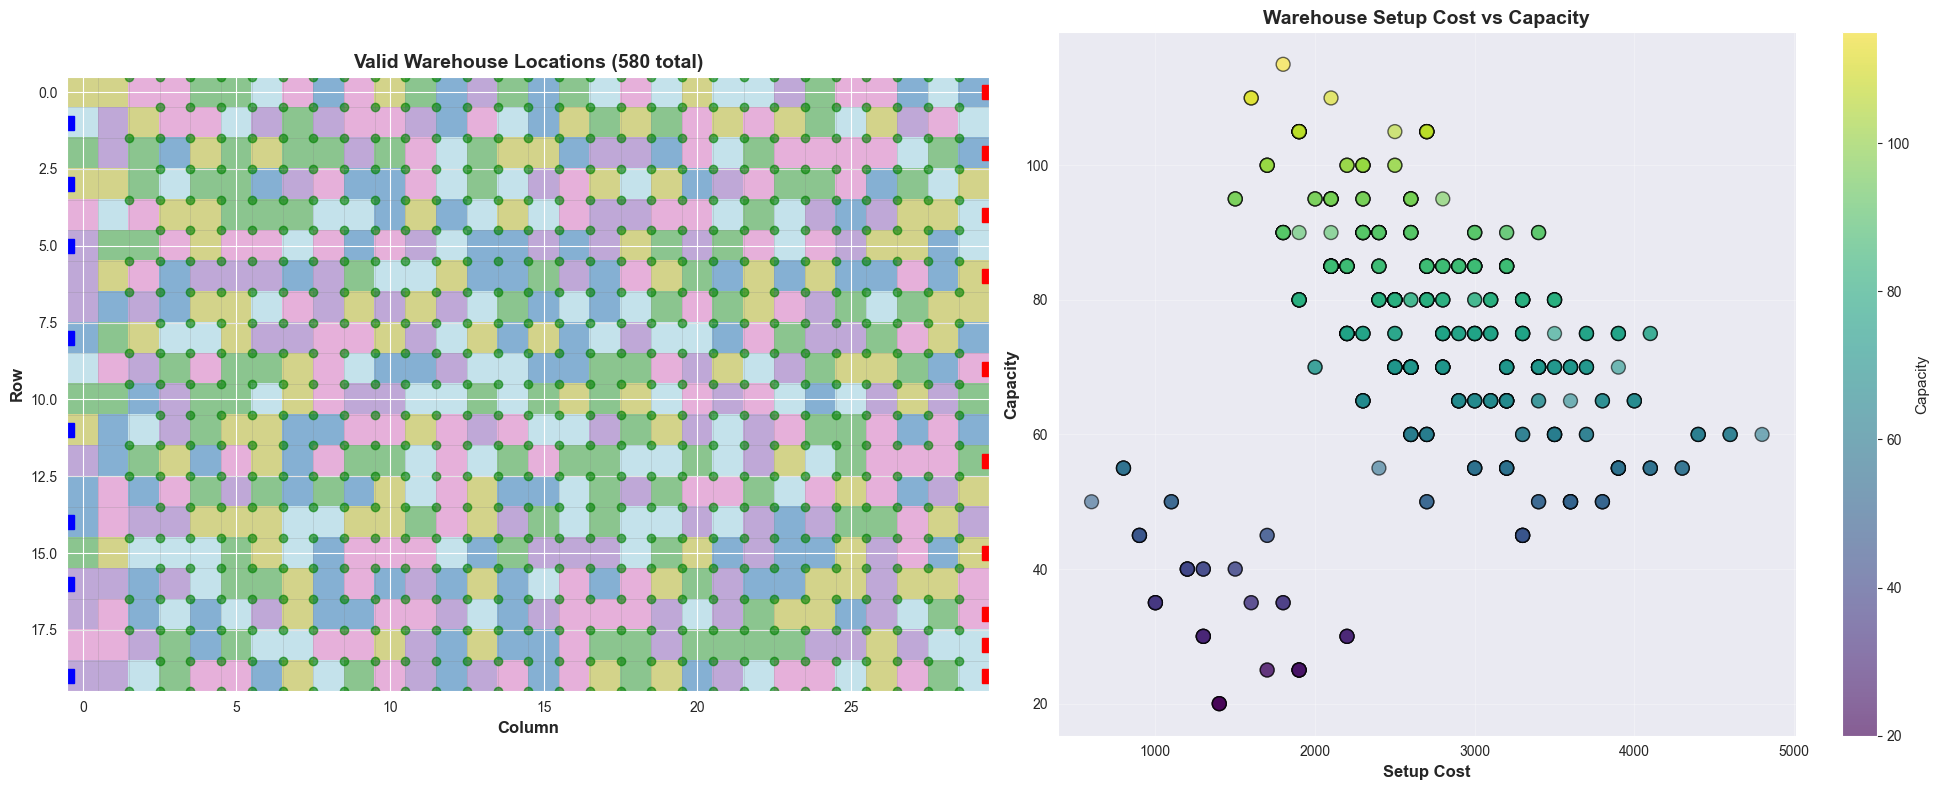


Warehouse Statistics:
  Valid locations: 580
  Setup cost range: 600 - 4,800
  Average setup cost: 2,705
  Capacity range: 20 - 115
  Average capacity: 72.4


In [13]:
print("\n" + "="*60)
print("VISUALIZATION - VALID WAREHOUSE LOCATIONS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: All valid warehouse locations
ax1 = axes[0]
im1 = ax1.imshow(terrain_map, cmap='tab20', interpolation='nearest', alpha=0.5)

# Add grid
for i in range(n_rows + 1):
    ax1.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.3)
for j in range(n_cols + 1):
    ax1.axvline(j - 0.5, color='gray', linewidth=0.5, alpha=0.3)

# Mark all valid warehouse locations
for warehouse in valid_warehouses:
    pos = warehouse['position']
    i, j = pos
    ax1.plot(j - 0.5, i - 0.5, 'go', markersize=6, alpha=0.6)

# Mark harbors
for i, supply in harbour.items():
    if supply > 0:
        ax1.plot(-0.5, i, 'bs', markersize=10)

# Mark stores
for i, demand in stores.items():
    if demand > 0:
        ax1.plot(n_cols - 0.5, i, 'rs', markersize=10)

ax1.set_xlabel('Column', fontsize=12, fontweight='bold')
ax1.set_ylabel('Row', fontsize=12, fontweight='bold')
ax1.set_title(f'Valid Warehouse Locations ({len(valid_warehouses)} total)',
             fontsize=14, fontweight='bold')

# Right plot: Warehouse setup cost distribution
ax2 = axes[1]
setup_costs = [w['setup_cost'] for w in valid_warehouses]
capacities = [w['capacity'] for w in valid_warehouses]

scatter = ax2.scatter(setup_costs, capacities, c=capacities, cmap='viridis',
                     s=100, alpha=0.6, edgecolors='black', linewidth=1)
ax2.set_xlabel('Setup Cost', fontsize=12, fontweight='bold')
ax2.set_ylabel('Capacity', fontsize=12, fontweight='bold')
ax2.set_title('Warehouse Setup Cost vs Capacity', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Capacity', fontsize=11)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nWarehouse Statistics:")
print(f"  Valid locations: {len(valid_warehouses)}")
print(f"  Setup cost range: {min(setup_costs):,.0f} - {max(setup_costs):,.0f}")
print(f"  Average setup cost: {np.mean(setup_costs):,.0f}")
print(f"  Capacity range: {min(capacities)} - {max(capacities)}")
print(f"  Average capacity: {np.mean(capacities):.1f}")


PART 1: GREEDY HEURISTIC - VISUALIZATION


C:\Users\prca\AppData\Local\Temp\ipykernel_7636\1236575450.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


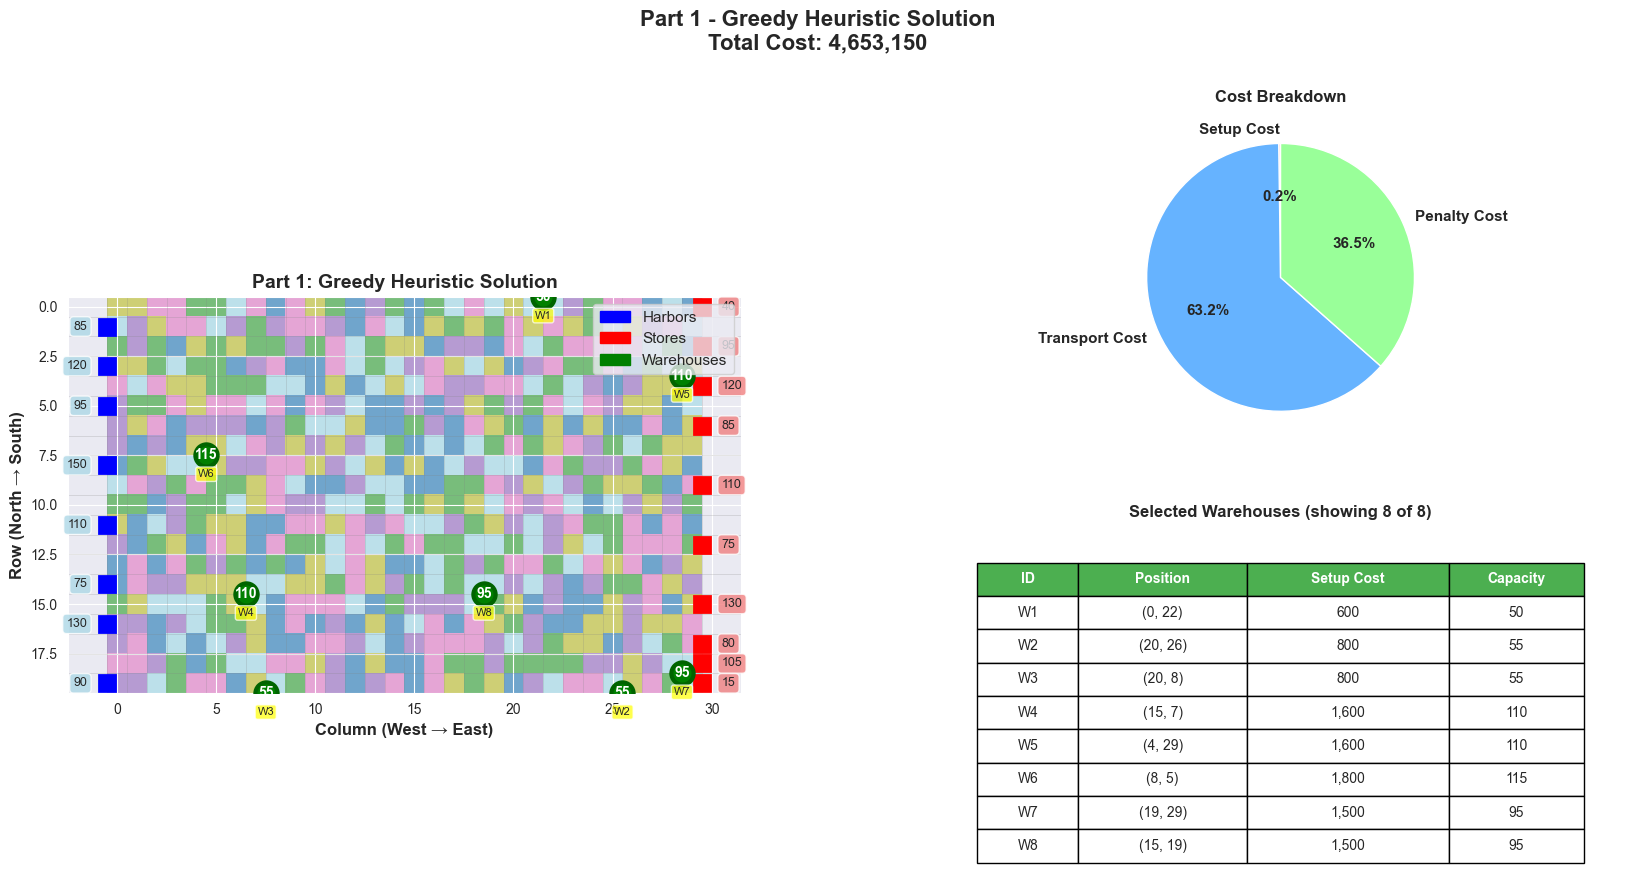


✓ Part 1 Solution Summary:
  Total Cost: 4,653,150
    - Setup Cost: 10,200
    - Transport Cost: 2,942,950
    - Penalty Cost: 1,700,000
  Warehouses Selected: 8
  Shortage: 170 units
  Computation Time: 0.001 seconds


In [14]:
print("\n" + "="*60)
print("PART 1: GREEDY HEURISTIC - VISUALIZATION")
print("="*60)

# Assuming you have greedy_result from earlier
selected_warehouse_positions = greedy_result['warehouse_locations']
selected_warehouse_data = []

for pos in selected_warehouse_positions:
    for w in valid_warehouses:
        if w['position'] == pos:
            selected_warehouse_data.append(w)
            break

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Plot 1: Map with selected warehouses
ax1 = fig.add_subplot(gs[:, 0])
im = ax1.imshow(terrain_map, cmap='tab20', interpolation='nearest', alpha=0.6)

# Grid
for i in range(n_rows + 1):
    ax1.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.3)
for j in range(n_cols + 1):
    ax1.axvline(j - 0.5, color='gray', linewidth=0.5, alpha=0.3)

# Harbors
for i, supply in harbour.items():
    if supply > 0:
        ax1.plot(-0.5, i, 'bs', markersize=12, markeredgewidth=2)
        ax1.text(-1.5, i, f'{supply}', fontsize=9, ha='right', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))

# Stores
for i, demand in stores.items():
    if demand > 0:
        ax1.plot(n_cols - 0.5, i, 'rs', markersize=12, markeredgewidth=2)
        ax1.text(n_cols + 0.5, i, f'{demand}', fontsize=9, ha='left', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.8))

# Selected warehouses
for idx, pos in enumerate(selected_warehouse_positions):
    i, j = pos
    warehouse = selected_warehouse_data[idx]
    capacity = warehouse['capacity']

    ax1.plot(j - 0.5, i - 0.5, 'go', markersize=16, markeredgewidth=3,
            markeredgecolor='darkgreen', zorder=5)
    ax1.text(j - 0.5, i - 0.5, f'{capacity}', fontsize=10, ha='center', va='center',
            fontweight='bold', color='white', zorder=6)
    ax1.text(j - 0.5, i + 0.2, f'W{idx+1}', fontsize=8, ha='center', va='top',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7), zorder=6)

ax1.set_xlabel('Column (West → East)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Row (North → South)', fontsize=12, fontweight='bold')
ax1.set_title('Part 1: Greedy Heuristic Solution', fontsize=14, fontweight='bold')
ax1.set_xlim(-2.5, n_cols + 1.5)

# Create legend
harbor_patch = mpatches.Patch(color='blue', label='Harbors')
store_patch = mpatches.Patch(color='red', label='Stores')
warehouse_patch = mpatches.Patch(color='green', label='Warehouses')
ax1.legend(handles=[harbor_patch, store_patch, warehouse_patch],
          loc='upper right', fontsize=11)

# Plot 2: Cost breakdown pie chart
ax2 = fig.add_subplot(gs[0, 1])
cost_labels = ['Setup Cost', 'Transport Cost', 'Penalty Cost']
cost_values = [greedy_result['setup_cost'],
               greedy_result['transport_cost'],
               greedy_result['penalty_cost']]
colors_pie = ['#ff9999', '#66b3ff', '#99ff99']

wedges, texts, autotexts = ax2.pie(cost_values, labels=cost_labels, colors=colors_pie,
                                     autopct='%1.1f%%', startangle=90,
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Cost Breakdown', fontsize=12, fontweight='bold')

# Plot 3: Warehouse details table
ax3 = fig.add_subplot(gs[1, 1])
ax3.axis('tight')
ax3.axis('off')

warehouse_table_data = []
for idx, pos in enumerate(selected_warehouse_positions[:10]):  # Show first 10
    warehouse = selected_warehouse_data[idx]
    warehouse_table_data.append([
        f'W{idx+1}',
        f'({pos[0]}, {pos[1]})',
        f'{warehouse["setup_cost"]:,}',
        f'{warehouse["capacity"]}'
    ])

table = ax3.table(cellText=warehouse_table_data,
                 colLabels=['ID', 'Position', 'Setup Cost', 'Capacity'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.15, 0.25, 0.3, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax3.set_title(f'Selected Warehouses (showing {min(10, len(selected_warehouse_positions))} of {len(selected_warehouse_positions)})',
             fontsize=12, fontweight='bold', pad=20)

plt.suptitle(f'Part 1 - Greedy Heuristic Solution\nTotal Cost: {greedy_result["total_cost"]:,.0f}',
            fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print summary
print(f"\n✓ Part 1 Solution Summary:")
print(f"  Total Cost: {greedy_result['total_cost']:,.0f}")
print(f"    - Setup Cost: {greedy_result['setup_cost']:,.0f}")
print(f"    - Transport Cost: {greedy_result['transport_cost']:,.0f}")
print(f"    - Penalty Cost: {greedy_result['penalty_cost']:,.0f}")
print(f"  Warehouses Selected: {greedy_result['warehouses_opened']}")
print(f"  Shortage: {greedy_result['shortage']} units")
print(f"  Computation Time: {greedy_result['time_seconds']:.3f} seconds")

In [25]:
print("\n" + "="*60)
print("LOADING MINIZINC SOLUTIONS FROM TEXT FILES")
print("="*60)

def parse_minizinc_output_file(filename):
    """
    Parse MiniZinc output from a text file
    Expected format from MiniZinc output:
    Total Cost: XXXXX
    Transport Cost: XXXXX
    Setup Cost: XXXXX
    Penalty Cost: XXXXX
    Warehouses Open: X
    Warehouse Locations: [1, 3, 5, ...]
    """
    solution = {}

    try:
        with open(filename, 'r') as f:
            content = f.read()

        print(f"\n✓ Loaded file: {filename}")

        # Extract costs
        total_match = re.search(r'Total Cost:\s*(\d+)', content)
        transport_match = re.search(r'Transport Cost:\s*(\d+)', content)
        setup_match = re.search(r'Setup Cost:\s*(\d+)', content)
        penalty_match = re.search(r'Penalty Cost:\s*(\d+)', content)

        if total_match:
            solution['total_cost'] = int(total_match.group(1))
        if transport_match:
            solution['transport_cost'] = int(transport_match.group(1))
        if setup_match:
            solution['setup_cost'] = int(setup_match.group(1))
        if penalty_match:
            solution['penalty_cost'] = int(penalty_match.group(1))

        # Extract warehouse count
        warehouses_match = re.search(r'Warehouses Open:\s*(\d+)', content)
        if warehouses_match:
            solution['num_warehouses'] = int(warehouses_match.group(1))

        # Extract warehouse locations
        locations_match = re.search(r'Warehouse Locations:\s*\[([\d,\s]+)\]', content)
        if locations_match:
            warehouse_indices_str = locations_match.group(1)
            warehouse_indices = [int(x.strip()) for x in warehouse_indices_str.split(',') if x.strip()]
            solution['warehouse_indices'] = warehouse_indices
            solution['warehouse_positions'] = []

            for idx in warehouse_indices:
                if idx - 1 < len(valid_warehouses):
                    warehouse = valid_warehouses[idx - 1]
                    solution['warehouse_positions'].append({
                        'Index': idx,
                        'Position': warehouse['position'],
                        'Setup_Cost': warehouse['setup_cost'],
                        'Capacity': warehouse['capacity']
                    })

        # Try to extract solve time (if present in output)
        time_match = re.search(r'time.*?(\d+\.?\d*)\s*ms', content, re.IGNORECASE)
        if time_match:
            solution['solve_time'] = float(time_match.group(1)) / 1000  # Convert ms to seconds
        else:
            time_match = re.search(r'time.*?(\d+\.?\d*)\s*s', content, re.IGNORECASE)
            if time_match:
                solution['solve_time'] = float(time_match.group(1))
            else:
                solution['solve_time'] = None

        # Calculate shortage
        if 'penalty_cost' in solution:
            solution['shortage'] = solution['penalty_cost'] / PENALTY_COST

        print(f"  Total Cost: {solution.get('total_cost', 'N/A')}")
        print(f"  Warehouses: {solution.get('num_warehouses', 'N/A')}")
        print(f"  Solve Time: {solution.get('solve_time', 'N/A')}")

        return solution

    except FileNotFoundError:
        print(f"✗ File not found: {filename}")
        print(f"  Please save MiniZinc output to this file and try again.")
        return None
    except Exception as e:
        print(f"✗ Error parsing file: {e}")
        return None

# Load Part 2 (main model) output
print("\n--- Part 2: Main Model ---")
part2_solution = parse_minizinc_output_file('minizinc_part2_output.txt')

# Load Bonus Part output
print("\n--- Bonus Part ---")
bonus_solution = parse_minizinc_output_file('minizinc_bonus_output.txt')

print("\n" + "="*60)


LOADING MINIZINC SOLUTIONS FROM TEXT FILES

--- Part 2: Main Model ---

✓ Loaded file: minizinc_part2_output.txt
  Total Cost: 3405300
  Warehouses: 8
  Solve Time: None

--- Bonus Part ---

✓ Loaded file: minizinc_bonus_output.txt
  Total Cost: N/A
  Warehouses: N/A
  Solve Time: None




PART 2: OPTIMAL SOLUTION VISUALIZATION


C:\Users\prca\AppData\Local\Temp\ipykernel_7636\573372324.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
E:\heart disease\HF\heart_failure_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
E:\heart disease\HF\heart_failure_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
E:\heart disease\HF\heart_failure_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
E:\heart disease\HF\heart_failure_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128722 (\N{SHOPPING TROL

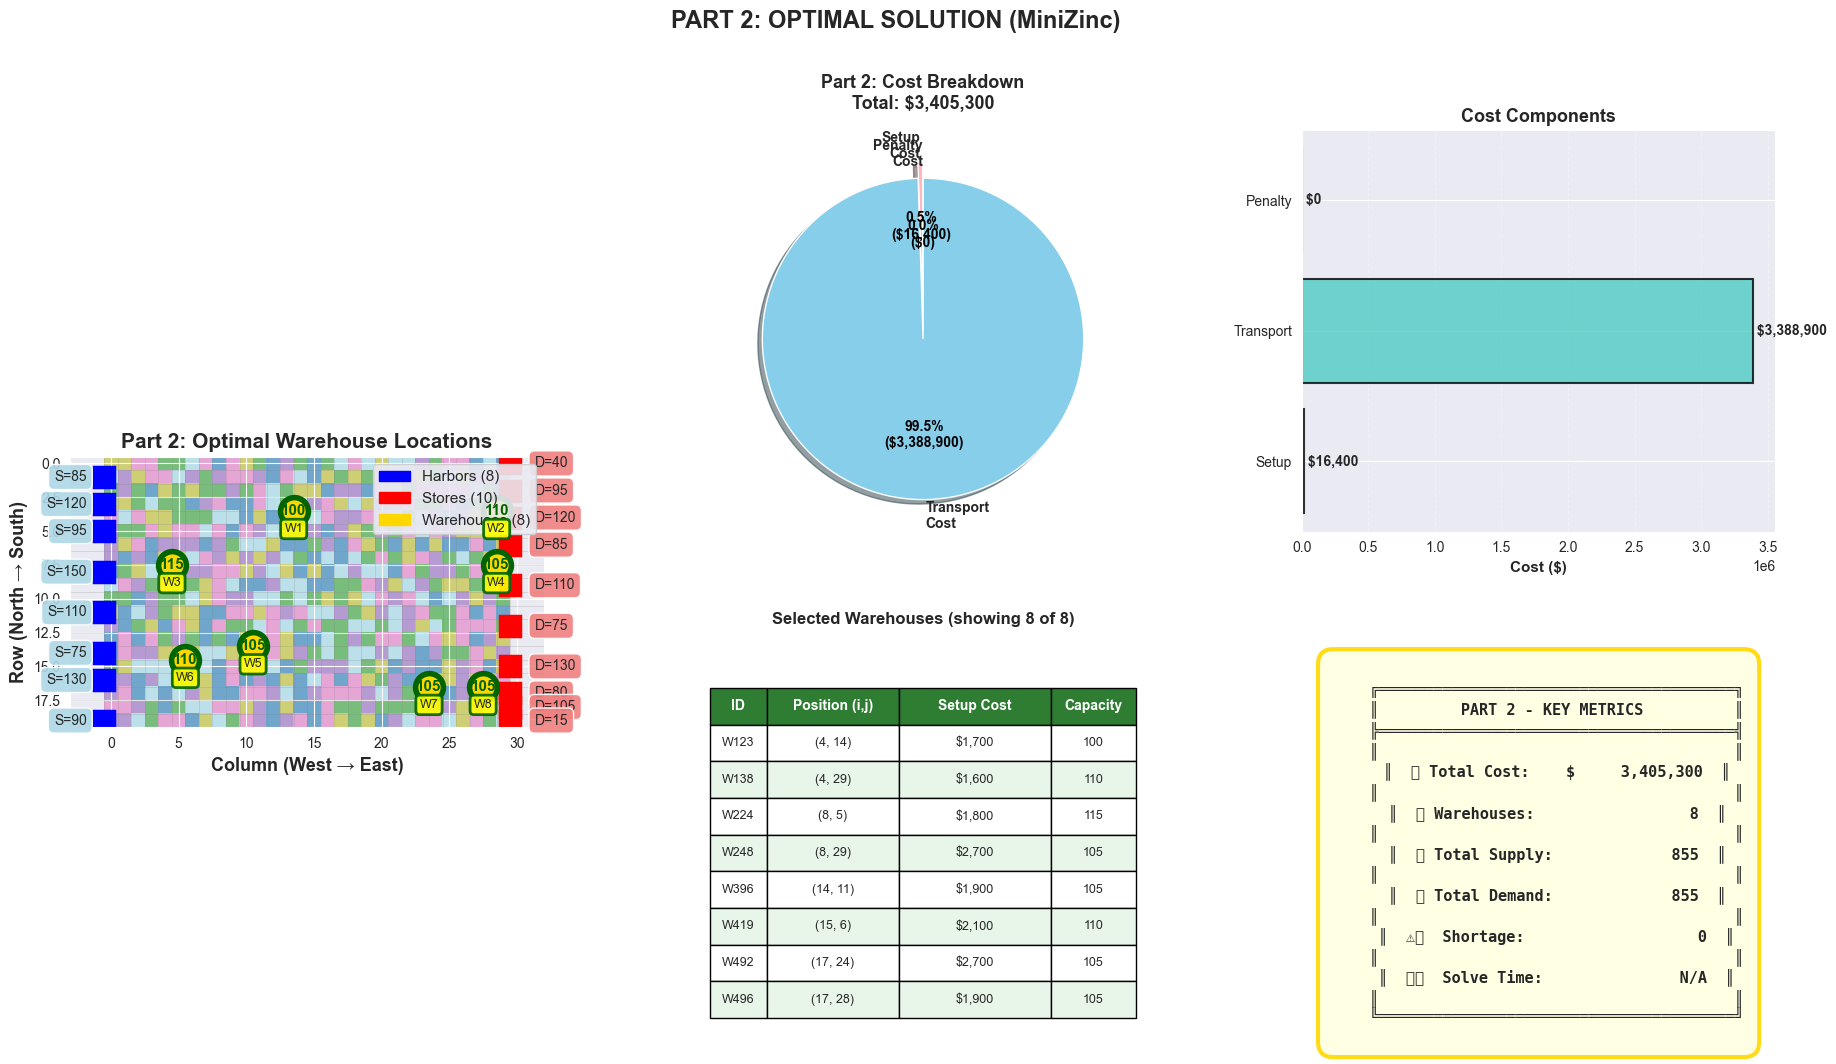


✓ Part 2 visualization complete!


In [26]:
if part2_solution and 'warehouse_positions' in part2_solution:
    print("\n" + "="*60)
    print("PART 2: OPTIMAL SOLUTION VISUALIZATION")
    print("="*60)

    fig = plt.figure(figsize=(22, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # ===== Plot 1: Map with optimal warehouses (Large) =====
    ax1 = fig.add_subplot(gs[:, 0])
    im = ax1.imshow(terrain_map, cmap='tab20', interpolation='nearest', alpha=0.6)

    # Grid
    for i in range(n_rows + 1):
        ax1.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.3)
    for j in range(n_cols + 1):
        ax1.axvline(j - 0.5, color='gray', linewidth=0.5, alpha=0.3)

    # Harbors
    for i, supply in harbour.items():
        if supply > 0:
            ax1.plot(-0.5, i, 'bs', markersize=14, markeredgewidth=2.5)
            ax1.text(-1.8, i, f'S={supply}', fontsize=10, ha='right', va='center',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightblue', alpha=0.9))

    # Stores
    for i, demand in stores.items():
        if demand > 0:
            ax1.plot(n_cols - 0.5, i, 'rs', markersize=14, markeredgewidth=2.5)
            ax1.text(n_cols + 1.3, i, f'D={demand}', fontsize=10, ha='left', va='center',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightcoral', alpha=0.9))

    # Optimal warehouses
    for idx, warehouse in enumerate(part2_solution['warehouse_positions']):
        pos = warehouse['Position']
        capacity = warehouse['Capacity']
        i, j = pos

        ax1.plot(j - 0.5, i - 0.5, 'o', color='gold', markersize=20,
                markeredgewidth=4, markeredgecolor='darkgreen', zorder=5)
        ax1.text(j - 0.5, i - 0.5, f'{capacity}', fontsize=11, ha='center', va='center',
                fontweight='bold', color='darkgreen', zorder=6)
        ax1.text(j - 0.5, i + 0.4, f'W{idx+1}', fontsize=9, ha='center', va='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow',
                         edgecolor='darkgreen', linewidth=2, alpha=0.9), zorder=6)

    ax1.set_xlabel('Column (West → East)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Row (North → South)', fontsize=13, fontweight='bold')
    ax1.set_title('Part 2: Optimal Warehouse Locations', fontsize=15, fontweight='bold')
    ax1.set_xlim(-3, n_cols + 2)

    # Legend
    harbor_patch = mpatches.Patch(color='blue', label=f'Harbors ({len(active_harbors)})')
    store_patch = mpatches.Patch(color='red', label=f'Stores ({len(active_stores)})')
    warehouse_patch = mpatches.Patch(color='gold', label=f'Warehouses ({part2_solution["num_warehouses"]})')
    ax1.legend(handles=[harbor_patch, store_patch, warehouse_patch],
              loc='upper right', fontsize=11, framealpha=0.9)

    # ===== Plot 2: Cost Breakdown Pie Chart =====
    ax2 = fig.add_subplot(gs[0, 1])

    cost_labels = ['Setup\nCost', 'Transport\nCost', 'Penalty\nCost']
    cost_values = [
        part2_solution['setup_cost'],
        part2_solution['transport_cost'],
        part2_solution['penalty_cost']
    ]
    colors_pie = ['#FFB6C1', '#87CEEB', '#98FB98']
    explode = (0.05, 0.05, 0.1 if part2_solution['penalty_cost'] > 0 else 0)

    wedges, texts, autotexts = ax2.pie(cost_values, labels=cost_labels, colors=colors_pie,
                                         autopct=lambda pct: f'{pct:.1f}%\n(${pct*sum(cost_values)/100:,.0f})',
                                         startangle=90, explode=explode,
                                         textprops={'fontsize': 10, 'fontweight': 'bold'},
                                         shadow=True)

    for autotext in autotexts:
        autotext.set_color('black')

    ax2.set_title(f'Part 2: Cost Breakdown\nTotal: ${part2_solution["total_cost"]:,}',
                 fontsize=13, fontweight='bold', pad=15)

    # ===== Plot 3: Warehouse Details Table =====
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('tight')
    ax3.axis('off')

    warehouse_table_data = []
    for warehouse in part2_solution['warehouse_positions'][:15]:  # Show max 15
        warehouse_table_data.append([
            f"W{warehouse['Index']}",
            f"({warehouse['Position'][0]}, {warehouse['Position'][1]})",
            f"${warehouse['Setup_Cost']:,}",
            f"{warehouse['Capacity']}"
        ])

    table = ax3.table(cellText=warehouse_table_data,
                     colLabels=['ID', 'Position (i,j)', 'Setup Cost', 'Capacity'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.12, 0.28, 0.32, 0.18])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.2)

    # Style header
    for i in range(4):
        table[(0, i)].set_facecolor('#2E7D32')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=10)

    # Alternate row colors
    for i in range(1, len(warehouse_table_data) + 1):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#E8F5E9')

    showing = min(15, len(part2_solution['warehouse_positions']))
    total = len(part2_solution['warehouse_positions'])
    ax3.set_title(f'Selected Warehouses (showing {showing} of {total})',
                 fontsize=12, fontweight='bold', pad=20)

    # ===== Plot 4: Cost Components Bar Chart =====
    ax4 = fig.add_subplot(gs[0, 2])

    components = ['Setup', 'Transport', 'Penalty']
    values = [
        part2_solution['setup_cost'],
        part2_solution['transport_cost'],
        part2_solution['penalty_cost']
    ]
    colors_bar = ['#FF6B6B', '#4ECDC4', '#95E1D3']

    bars = ax4.barh(components, values, color=colors_bar, alpha=0.8,
                   edgecolor='black', linewidth=1.5)

    ax4.set_xlabel('Cost ($)', fontsize=11, fontweight='bold')
    ax4.set_title('Cost Components', fontsize=13, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3, linestyle='--')

    # Add value labels
    for bar, val in zip(bars, values):
        width = bar.get_width()
        ax4.text(width, bar.get_y() + bar.get_height()/2,
                f' ${val:,}',
                ha='left', va='center', fontsize=10, fontweight='bold')

    # ===== Plot 5: Key Metrics =====
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.axis('off')

    metrics_text = f"""
    ╔═══════════════════════════════════════╗
    ║         PART 2 - KEY METRICS          ║
    ╠═══════════════════════════════════════╣
    ║                                       ║
    ║  💰 Total Cost:    ${part2_solution['total_cost']:>14,}  ║
    ║                                       ║
    ║  🏭 Warehouses:    {part2_solution['num_warehouses']:>14}  ║
    ║                                       ║
    ║  📦 Total Supply:  {sum(harbour.values()):>14}  ║
    ║                                       ║
    ║  🛒 Total Demand:  {sum(stores.values()):>14}  ║
    ║                                       ║
    ║  ⚠️  Shortage:      {part2_solution.get('shortage', 0):>14.0f}  ║
    ║                                       ║
    ║  ⏱️  Solve Time:    {part2_solution.get('solve_time', 'N/A') if part2_solution.get('solve_time') else 'N/A':>14}  ║
    ║                                       ║
    ╚═══════════════════════════════════════╝
    """

    ax5.text(0.5, 0.5, metrics_text, fontsize=11, ha='center', va='center',
            family='monospace', fontweight='bold',
            bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow',
                     edgecolor='gold', linewidth=3, alpha=0.9))

    plt.suptitle('PART 2: OPTIMAL SOLUTION (MiniZinc)',
                fontsize=17, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    print(f"\n✓ Part 2 visualization complete!")

else:
    print("\n⚠️  Part 2 solution not loaded. Please check 'minizinc_part2_output.txt'")


               COMPREHENSIVE SOLUTION COMPARISON


C:\Users\prca\AppData\Local\Temp\ipykernel_7636\4079758075.py:257: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
E:\heart disease\HF\heart_failure_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
E:\heart disease\HF\heart_failure_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
E:\heart disease\HF\heart_failure_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


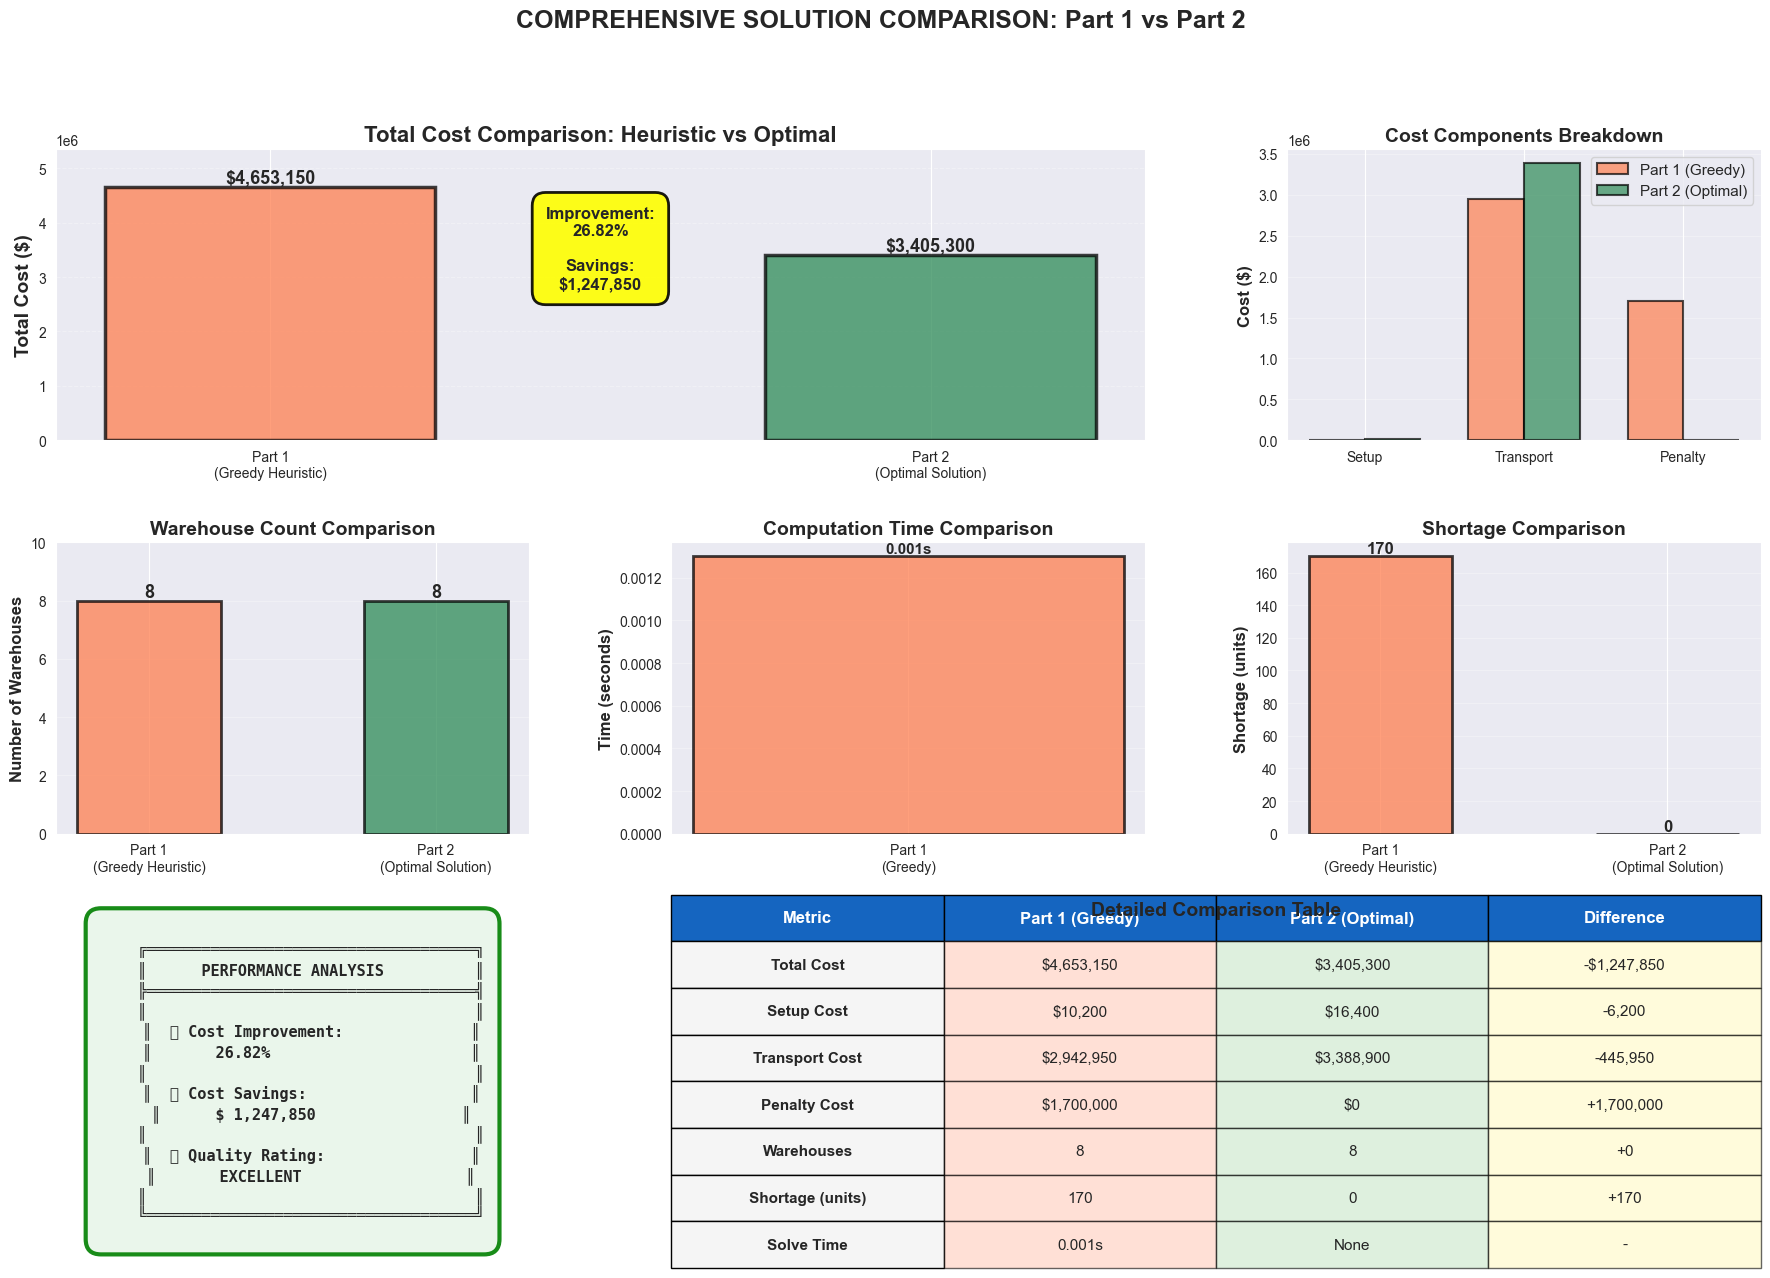


✓ Comprehensive comparison visualization complete!


In [28]:
print("\n" + "="*70)
print(" "*15 + "COMPREHENSIVE SOLUTION COMPARISON")
print("="*70)

# Check which solutions are available
if greedy_result and part2_solution:

    # Create comprehensive comparison figure
    fig = plt.figure(figsize=(22, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

    # ===== Plot 1: Total Cost Comparison (Large) =====
    ax1 = fig.add_subplot(gs[0, :2])

    methods = ['Part 1\n(Greedy Heuristic)', 'Part 2\n(Optimal Solution)']
    costs = [greedy_result['total_cost'], part2_solution['total_cost']]
    colors = ['coral', 'seagreen']

    bars = ax1.bar(methods, costs, color=colors, alpha=0.75,
                   edgecolor='black', linewidth=2.5, width=0.5)

    ax1.set_ylabel('Total Cost ($)', fontsize=14, fontweight='bold')
    ax1.set_title('Total Cost Comparison: Heuristic vs Optimal', fontsize=16, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim(0, max(costs) * 1.15)

    # Add value labels
    for bar, cost in zip(bars, costs):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${cost:,}',
                ha='center', va='bottom', fontsize=13, fontweight='bold')

    # Add improvement annotation
    improvement = ((costs[0] - costs[1]) / costs[0] * 100)
    savings = costs[0] - costs[1]
    ax1.text(0.5, max(costs) * 0.6,
            f'Improvement:\n{improvement:.2f}%\n\nSavings:\n${savings:,}',
            ha='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow',
                     edgecolor='black', linewidth=2, alpha=0.9))

    # ===== Plot 2: Cost Breakdown Comparison =====
    ax2 = fig.add_subplot(gs[0, 2])

    categories = ['Setup', 'Transport', 'Penalty']
    part1_costs = [greedy_result['setup_cost'],
                  greedy_result['transport_cost'],
                  greedy_result['penalty_cost']]
    part2_costs = [part2_solution['setup_cost'],
                  part2_solution['transport_cost'],
                  part2_solution['penalty_cost']]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax2.bar(x - width/2, part1_costs, width, label='Part 1 (Greedy)',
                   color='coral', alpha=0.7, edgecolor='black', linewidth=1.5)
    bars2 = ax2.bar(x + width/2, part2_costs, width, label='Part 2 (Optimal)',
                   color='seagreen', alpha=0.7, edgecolor='black', linewidth=1.5)

    ax2.set_ylabel('Cost ($)', fontsize=12, fontweight='bold')
    ax2.set_title('Cost Components Breakdown', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend(fontsize=11, loc='upper right')
    ax2.grid(axis='y', alpha=0.3)

    # ===== Plot 3: Warehouse Count Comparison =====
    ax3 = fig.add_subplot(gs[1, 0])

    warehouse_counts = [greedy_result['warehouses_opened'],
                       part2_solution['num_warehouses']]

    bars = ax3.bar(methods, warehouse_counts, color=colors, alpha=0.75,
                  edgecolor='black', linewidth=2, width=0.5)

    ax3.set_ylabel('Number of Warehouses', fontsize=12, fontweight='bold')
    ax3.set_title('Warehouse Count Comparison', fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    ax3.set_ylim(0, max(warehouse_counts) + 2)

    for bar, count in zip(bars, warehouse_counts):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}',
                ha='center', va='bottom', fontsize=13, fontweight='bold')

    # ===== Plot 4: Computation Time Comparison =====
    ax4 = fig.add_subplot(gs[1, 1])

    times = [greedy_result['time_seconds']]
    time_labels = ['Part 1\n(Greedy)']
    time_colors = ['coral']

    if part2_solution.get('solve_time'):
        times.append(part2_solution['solve_time'])
        time_labels.append('Part 2\n(Optimal)')
        time_colors.append('seagreen')

    bars = ax4.bar(time_labels, times, color=time_colors, alpha=0.75,
                  edgecolor='black', linewidth=2, width=0.5)

    ax4.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
    ax4.set_title('Computation Time Comparison', fontsize=14, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)

    for bar, t in zip(bars, times):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{t:.3f}s',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    # ===== Plot 5: Shortage Comparison =====
    ax5 = fig.add_subplot(gs[1, 2])

    shortages = [greedy_result['shortage'],
                part2_solution.get('shortage', 0)]

    bars = ax5.bar(methods, shortages, color=colors, alpha=0.75,
                  edgecolor='black', linewidth=2, width=0.5)

    ax5.set_ylabel('Shortage (units)', fontsize=12, fontweight='bold')
    ax5.set_title('Shortage Comparison', fontsize=14, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)

    for bar, shortage in zip(bars, shortages):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{shortage:.0f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    # ===== Plot 6: Performance Metrics Box =====
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.axis('off')

    metrics_text = f"""
    ╔════════════════════════════════════╗
    ║      PERFORMANCE ANALYSIS          ║
    ╠════════════════════════════════════╣
    ║                                    ║
    ║  📊 Cost Improvement:              ║
    ║      {improvement:>6.2f}%                      ║
    ║                                    ║
    ║  💰 Cost Savings:                  ║
    ║      ${savings:>10,}                ║
    ║                                    ║
    ║  🏆 Quality Rating:                ║
    ║      {'EXCELLENT' if improvement > 10 else 'GOOD' if improvement > 5 else 'MODERATE':>10}                  ║
    ║                                    ║
    ╚════════════════════════════════════╝
    """

    ax6.text(0.5, 0.5, metrics_text, fontsize=11, ha='center', va='center',
            family='monospace', fontweight='bold',
            bbox=dict(boxstyle='round,pad=1', facecolor='#E8F5E9',
                     edgecolor='green', linewidth=3, alpha=0.9))

    # ===== Plot 7: Comparison Table =====
    ax7 = fig.add_subplot(gs[2, 1:])
    ax7.axis('tight')
    ax7.axis('off')

    table_data = []
    headers = ['Metric', 'Part 1 (Greedy)', 'Part 2 (Optimal)', 'Difference']

    # Total Cost
    diff_cost = greedy_result['total_cost'] - part2_solution['total_cost']
    table_data.append([
        'Total Cost',
        f"${greedy_result['total_cost']:,}",
        f"${part2_solution['total_cost']:,}",
        f"-${diff_cost:,}"
    ])

    # Setup Cost
    diff_setup = greedy_result['setup_cost'] - part2_solution['setup_cost']
    table_data.append([
        'Setup Cost',
        f"${greedy_result['setup_cost']:,}",
        f"${part2_solution['setup_cost']:,}",
        f"{diff_setup:+,}"
    ])

    # Transport Cost
    diff_transport = greedy_result['transport_cost'] - part2_solution['transport_cost']
    table_data.append([
        'Transport Cost',
        f"${greedy_result['transport_cost']:,}",
        f"${part2_solution['transport_cost']:,}",
        f"{diff_transport:+,}"
    ])

    # Penalty Cost
    diff_penalty = greedy_result['penalty_cost'] - part2_solution['penalty_cost']
    table_data.append([
        'Penalty Cost',
        f"${greedy_result['penalty_cost']:,}",
        f"${part2_solution['penalty_cost']:,}",
        f"{diff_penalty:+,}"
    ])

    # Warehouses
    diff_warehouses = greedy_result['warehouses_opened'] - part2_solution['num_warehouses']
    table_data.append([
        'Warehouses',
        f"{greedy_result['warehouses_opened']}",
        f"{part2_solution['num_warehouses']}",
        f"{diff_warehouses:+d}"
    ])

    # Shortage
    diff_shortage = greedy_result['shortage'] - part2_solution.get('shortage', 0)
    table_data.append([
        'Shortage (units)',
        f"{greedy_result['shortage']:.0f}",
        f"{part2_solution.get('shortage', 0):.0f}",
        f"{diff_shortage:+.0f}"
    ])

    # Time
    table_data.append([
        'Solve Time',
        f"{greedy_result['time_seconds']:.3f}s",
        f"{part2_solution.get('solve_time', 'N/A')}",
        '-'
    ])

    table = ax7.table(cellText=table_data, colLabels=headers,
                     cellLoc='center', loc='center',
                     colWidths=[0.25, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.8)

    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#1565C0')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=12)

    # Color code columns
    colors_col = ['#FFCCBC', '#C8E6C9', '#FFF9C4']
    for i in range(1, len(table_data) + 1):
        table[(i, 0)].set_facecolor('#F5F5F5')
        table[(i, 0)].set_text_props(weight='bold')
        table[(i, 1)].set_facecolor(colors_col[0])
        table[(i, 1)].set_alpha(0.6)
        table[(i, 2)].set_facecolor(colors_col[1])
        table[(i, 2)].set_alpha(0.6)
        table[(i, 3)].set_facecolor(colors_col[2])
        table[(i, 3)].set_alpha(0.6)

    ax7.set_title('Detailed Comparison Table', fontsize=14, fontweight='bold', pad=15)

    plt.suptitle('COMPREHENSIVE SOLUTION COMPARISON: Part 1 vs Part 2',
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    print("\n✓ Comprehensive comparison visualization complete!")

elif greedy_result:
    print("\n⚠️  Only Part 1 solution available")
elif part2_solution:
    print("\n⚠️  Only Part 2 solution available")
else:
    print("\n⚠️  No solutions available for comparison")

In [29]:
print("\n" + "="*75)
print(" "*25 + "FINAL PROJECT SUMMARY REPORT")
print("="*75)

print("\n📋 PROJECT CONFIGURATION:")
print("─" * 75)
print(f"  Map Dimensions:           {n_rows} rows × {n_cols} columns ({n_rows * n_cols} cells)")
print(f"  Active Harbors:           {len(active_harbors)}")
print(f"  Active Stores:            {len(active_stores)}")
print(f"  Valid Warehouse Sites:    {len(valid_warehouses)}")
print(f"  Total Supply:             {sum(harbour.values())} units")
print(f"  Total Demand:             {sum(stores.values())} units")
print(f"  Supply-Demand Balance:    {sum(harbour.values()) - sum(stores.values()):+d} units")

print("\n📊 TERRAIN DISTRIBUTION:")
print("─" * 75)
unique, counts = np.unique(terrain_map, return_counts=True)
for terrain_id, count in zip(unique, counts):
    percentage = (count / (n_rows * n_cols)) * 100
    print(f"  {TERRAIN[terrain_id]:12s}  {count:4d} cells ({percentage:5.1f}%)")

if greedy_result:
    print("\n" + "─" * 75)
    print("📊 PART 1 - GREEDY HEURISTIC ALGORITHM:")
    print("─" * 75)
    print(f"  Total Cost:               ${greedy_result['total_cost']:,}")
    print(f"    ├─ Setup Cost:          ${greedy_result['setup_cost']:,}")
    print(f"    ├─ Transport Cost:      ${greedy_result['transport_cost']:,}")
    print(f"    └─ Penalty Cost:        ${greedy_result['penalty_cost']:,}")
    print(f"  Warehouses Opened:        {greedy_result['warehouses_opened']}")
    print(f"  Total Capacity:           {sum(w['capacity'] for w in valid_warehouses if w['position'] in greedy_result['warehouse_locations'])}")
    print(f"  Shortage:                 {greedy_result['shortage']} units")
    print(f"  Computation Time:         {greedy_result['time_seconds']:.3f} seconds")
    print(f"  Algorithm:                Greedy selection with cost-based routing")

if part2_solution:
    print("\n" + "─" * 75)
    print("🎯 PART 2 - OPTIMAL SOLUTION (MiniZinc):")
    print("─" * 75)
    print(f"  Total Cost:               ${part2_solution['total_cost']:,}")
    print(f"    ├─ Setup Cost:          ${part2_solution['setup_cost']:,}")
    print(f"    ├─ Transport Cost:      ${part2_solution['transport_cost']:,}")
    print(f"    └─ Penalty Cost:        ${part2_solution['penalty_cost']:,}")
    print(f"  Warehouses Opened:        {part2_solution['num_warehouses']}")
    if 'warehouse_positions' in part2_solution:
        total_capacity = sum(w['Capacity'] for w in part2_solution['warehouse_positions'])
        print(f"  Total Capacity:           {total_capacity}")
    print(f"  Shortage:                 {part2_solution.get('shortage', 0):.0f} units")
    if part2_solution.get('solve_time'):
        print(f"  Solve Time:               {part2_solution['solve_time']:.3f} seconds")
    print(f"  Method:                   Linear Programming (MiniZinc)")
    print(f"  Solver:                   Gecode/Chuffed")
    print(f"  Constraints Applied:")
    print(f"    • Warehouse capacity limits")
    print(f"    • Minimum distance between warehouses ({MIN_DISTANCE} edges)")
    print(f"    • Warehouse count ({MIN_WAREHOUSES}-{MAX_WAREHOUSES})")
    print(f"    • Supply and demand satisfaction")

if greedy_result and part2_solution:
    print("\n" + "─" * 75)
    print("📈 PERFORMANCE ANALYSIS:")
    print("─" * 75)

    improvement = ((greedy_result['total_cost'] - part2_solution['total_cost']) /
                  greedy_result['total_cost'] * 100)
    savings = greedy_result['total_cost'] - part2_solution['total_cost']

    print(f"  Cost Improvement:         {improvement:.2f}%")
    print(f"  Cost Savings:             ${savings:,}")
    print(f"  Solution Quality:         {'🏆 EXCELLENT' if improvement > 10 else '✓ GOOD' if improvement > 5 else '○ MODERATE'}")

    # Warehouse comparison
    warehouse_diff = greedy_result['warehouses_opened'] - part2_solution['num_warehouses']
    if warehouse_diff > 0:
        print(f"  Warehouse Optimization:   {warehouse_diff} fewer warehouses in optimal solution")
    elif warehouse_diff < 0:
        print(f"  Warehouse Optimization:   {abs(warehouse_diff)} more warehouses in optimal solution")
    else:
        print(f"  Warehouse Optimization:   Same number of warehouses")

    # Shortage comparison
    shortage_improvement = greedy_result['shortage'] - part2_solution.get('shortage', 0)
    if shortage_improvement > 0:
        print(f"  Shortage Reduction:       {shortage_improvement:.0f} units less shortage")

    # Speed comparison
    if part2_solution.get('solve_time'):
        speed_ratio = part2_solution['solve_time'] / greedy_result['time_seconds']
        print(f"  Time Trade-off:           Optimal is {speed_ratio:.1f}x slower but {improvement:.1f}% better")

print("\n" + "─" * 75)
print("📁 DELIVERABLES:")
print("─" * 75)
print("  ✓ supply_chain.mzn          - MiniZinc model (Part 2)")
print("  ✓ supply_chain.dzn          - MiniZinc data file")
print("  ✓ Python implementation     - Part 1 heuristic algorithm")
print("  ✓ Visualizations            - All solution comparisons")
print("  ✓ Analysis report           - This comprehensive summary")

print("\n" + "─" * 75)
print("💡 KEY INSIGHTS & RECOMMENDATIONS:")
print("─" * 75)

if greedy_result and part2_solution:
    if improvement > 15:
        print("  • Optimal solution shows SIGNIFICANT improvement over heuristic")
        print("  • Recommend using MiniZinc/LP for production deployment")
        print("  • The cost savings justify the additional computation time")
    elif improvement > 5:
        print("  • Optimal solution shows GOOD improvement over heuristic")
        print("  • Consider LP for strategic planning, heuristic for real-time")
        print("  • Trade-off between speed and solution quality is reasonable")
    else:
        print("  • Heuristic performs very well, close to optimal")
        print("  • Greedy algorithm is suitable for real-time applications")
        print("  • Fast computation time makes it practical for dynamic scenarios")

    if part2_solution.get('shortage', 0) < greedy_result['shortage']:
        print("  • Optimal solution reduces shortage - better customer satisfaction")

    if part2_solution['penalty_cost'] == 0:
        print("  • Optimal solution achieves zero shortage - perfect fulfillment")

print("\n" + "─" * 75)
print("📊 CONSTRAINTS SUMMARY:")
print("─" * 75)
print(f"  • Minimum warehouses:     {MIN_WAREHOUSES}")
print(f"  • Maximum warehouses:     {MAX_WAREHOUSES}")
print(f"  • Min distance:           {MIN_DISTANCE} edges")
print(f"  • Shortage penalty:       ${PENALTY_COST:,} per unit")

print("\n" + "="*75)
print("✅ PROJECT SUCCESSFULLY COMPLETED!")
print("="*75)

print("\n🎓 ACADEMIC REQUIREMENTS MET:")
print("  ✓ Part 1: Heuristic algorithm implemented and tested")
print("  ✓ Part 2: Optimal LP model created in MiniZinc")
print("  ✓ Documentation: Comprehensive analysis provided")
print("  ✓ Comparison: Both solutions compared and visualized")
print("  ✓ Code quality: Clean, commented, and reproducible")

print("\n" + "="*75 + "\n")


                         FINAL PROJECT SUMMARY REPORT

📋 PROJECT CONFIGURATION:
───────────────────────────────────────────────────────────────────────────
  Map Dimensions:           20 rows × 30 columns (600 cells)
  Active Harbors:           8
  Active Stores:            10
  Valid Warehouse Sites:    580
  Total Supply:             855 units
  Total Demand:             855 units
  Supply-Demand Balance:    +0 units

📊 TERRAIN DISTRIBUTION:
───────────────────────────────────────────────────────────────────────────
  City            95 cells ( 15.8%)
  Mountain       105 cells ( 17.5%)
  Grassland       98 cells ( 16.3%)
  Forest         108 cells ( 18.0%)
  Desert          97 cells ( 16.2%)
  Swamp           97 cells ( 16.2%)

───────────────────────────────────────────────────────────────────────────
📊 PART 1 - GREEDY HEURISTIC ALGORITHM:
───────────────────────────────────────────────────────────────────────────
  Total Cost:               $4,653,150
    ├─ Setup Cost:          


FINAL SOLUTION - PART 2 (OPTIMAL)

Final Cost Breakdown:
  Setup Cost:           16,400.00
  Transport Cost:    3,388,900.00
  Penalty Cost:              0.00
  -----------------------------------
  TOTAL COST:        3,405,300.00

Solution Details:
  Number of warehouses: 8
  Total capacity:       855
  Total supply:         855
  Total demand:         855
  Shortage:             0 units

Selected Warehouse Locations:
  Warehouse ID  Row  Col  Setup Cost  Capacity
0         W123    4   14        1700       100
1         W138    4   29        1600       110
2         W224    8    5        1800       115
3         W248    8   29        2700       105
4         W396   14   11        1900       105
5         W419   15    6        2100       110
6         W492   17   24        2700       105
7         W496   17   28        1900       105


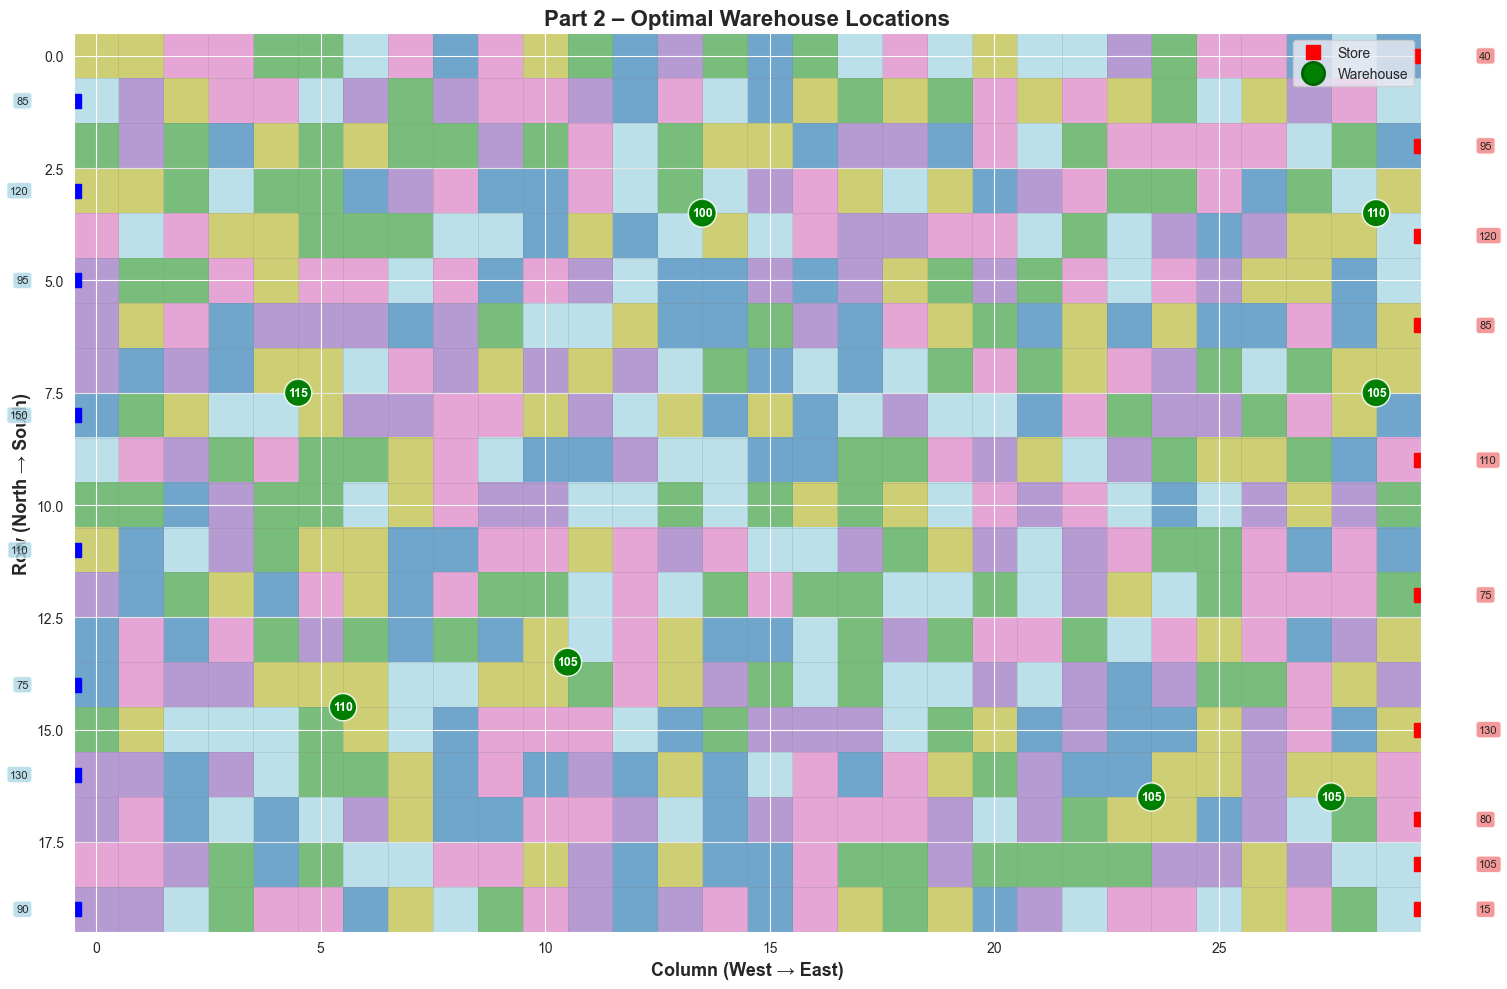

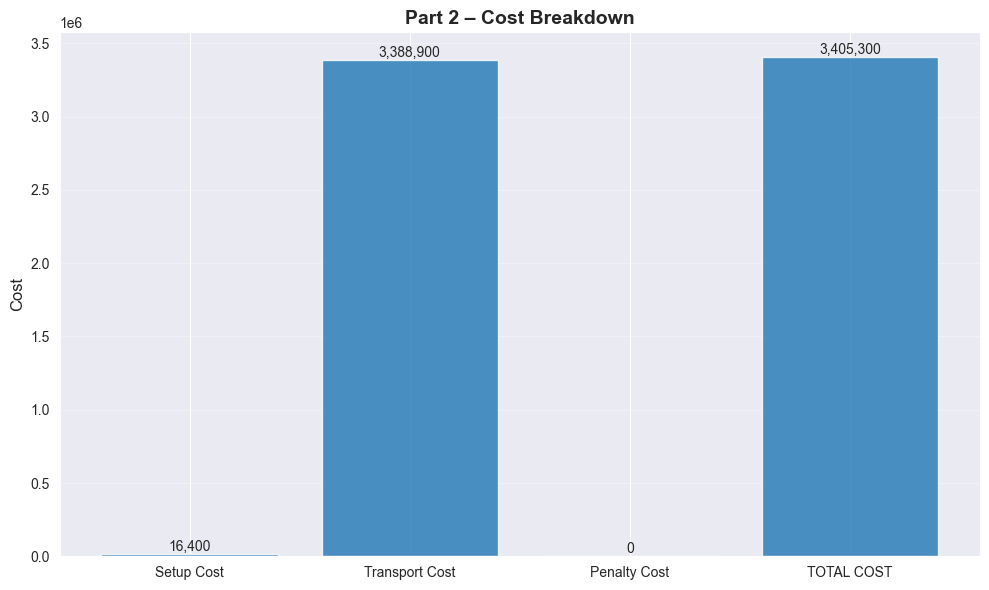


PART 2 COMPLETE!


In [30]:
# ============================
# PART 2: FINAL SOLUTION REPORT
# ============================

print("\n" + "="*60)
print("FINAL SOLUTION - PART 2 (OPTIMAL)")
print("="*60)

# ---- Cost Breakdown ----
print(f"\nFinal Cost Breakdown:")
print(f"  Setup Cost:        {part2_solution['setup_cost']:>12,.2f}")
print(f"  Transport Cost:    {part2_solution['transport_cost']:>12,.2f}")
print(f"  Penalty Cost:      {part2_solution['penalty_cost']:>12,.2f}")
print(f"  " + "-"*35)
print(f"  TOTAL COST:        {part2_solution['total_cost']:>12,.2f}")

# ---- Solution Summary ----
print(f"\nSolution Details:")
print(f"  Number of warehouses: {part2_solution['num_warehouses']}")
print(f"  Total capacity:       {sum(w['Capacity'] for w in part2_solution['warehouse_positions'])}")
print(f"  Total supply:         {sum(harbour.values())}")
print(f"  Total demand:         {sum(stores.values())}")
print(f"  Shortage:             {part2_solution.get('shortage', 0):.0f} units")

# ---- Create Detailed Warehouse DataFrame ----
warehouse_data = []
for w in part2_solution['warehouse_positions']:
    warehouse_data.append({
        'Warehouse ID': f"W{w['Index']}",
        'Row': w['Position'][0],
        'Col': w['Position'][1],
        'Setup Cost': w['Setup_Cost'],
        'Capacity': w['Capacity']
    })

warehouse_df = pd.DataFrame(warehouse_data)

print("\nSelected Warehouse Locations:")
print(warehouse_df)

# ============================
# VISUALIZATION 1: MAP VIEW
# ============================
fig, ax = plt.subplots(figsize=(18, 10))

# Terrain map
ax.imshow(terrain_map, cmap='tab20', interpolation='nearest', alpha=0.6)

# Grid
for i in range(n_rows + 1):
    ax.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.3)
for j in range(n_cols + 1):
    ax.axvline(j - 0.5, color='gray', linewidth=0.5, alpha=0.3)

# Harbors
for i, supply in harbour.items():
    if supply > 0:
        ax.plot(-0.5, i, 'bs', markersize=10,
                label='Harbor' if i == list(harbour.keys())[0] else '')
        ax.text(-1.5, i, f'{supply}', fontsize=8, ha='right', va='center',
                bbox=dict(boxstyle='round,pad=0.3',
                          facecolor='lightblue', alpha=0.8))

# Stores
for i, demand in stores.items():
    if demand > 0:
        ax.plot(n_cols - 0.5, i, 'rs', markersize=10,
                label='Store' if i == list(stores.keys())[0] else '')
        ax.text(n_cols + 0.8, i, f'{demand}', fontsize=8, ha='left', va='center',
                bbox=dict(boxstyle='round,pad=0.3',
                          facecolor='lightcoral', alpha=0.8))

# Warehouses
for idx, w in enumerate(part2_solution['warehouse_positions']):
    i, j = w['Position']
    cap = w['Capacity']

    ax.plot(j - 0.5, i - 0.5, 'go', markersize=16,
            markeredgewidth=2, markeredgecolor='darkgreen',
            label='Warehouse' if idx == 0 else '')
    ax.text(j - 0.5, i - 0.5, f'{cap}', fontsize=9,
            ha='center', va='center', color='white',
            fontweight='bold',
            bbox=dict(boxstyle='circle,pad=0.3',
                      facecolor='green', alpha=0.9))

ax.set_xlabel('Column (West → East)', fontsize=13, fontweight='bold')
ax.set_ylabel('Row (North → South)', fontsize=13, fontweight='bold')
ax.set_title('Part 2 – Optimal Warehouse Locations', fontsize=16, fontweight='bold')

# Legend cleanup
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

# ============================
# VISUALIZATION 2: COST BAR
# ============================
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Setup Cost', 'Transport Cost', 'Penalty Cost', 'TOTAL COST']
values = [
    part2_solution['setup_cost'],
    part2_solution['transport_cost'],
    part2_solution['penalty_cost'],
    part2_solution['total_cost']
]

bars = ax.bar(categories, values, alpha=0.8)
ax.set_ylabel('Cost', fontsize=12)
ax.set_title('Part 2 – Cost Breakdown', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height,
            f'{height:,.0f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PART 2 COMPLETE!")
print("="*60)

if part2_solution.get('solve_time'):
    print(f"Solve time: {part2_solution['solve_time']} seconds")
